In [21]:
import numpy as np
import os
import torch
import torch.distributions as distributions
from torch.optim import Adam
from torch.optim import LBFGS
import tensorly as tl
from torch.autograd import Variable
from sklearn.cluster import KMeans
# from kernels import KernelRBF
# from kernels import KernelARD
from sklearn import metrics
from scipy.io import loadmat
import random

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)
tl.set_backend('pytorch')

#using ard kernel for the actual input
size = int(10000 / 5 + 1)
epochs = np.ones(size)
test_rmse = np.ones(size)
test_nrmse = np.ones(size)
test_mae = np.ones(size)
test_nmae = np.ones(size)

class KernelRBF:
    def __init__(self, jitter):
        self.jitter = jitter
        
    def matrix(self, X, ls):
        K = self.cross(X, X, ls)
        Ijit = self.jitter*torch.eye(X.shape[0]).to(K.device)
        K = K + Ijit
        return K
        
        
    def cross(self, X1, X2, ls):
        norm1 = torch.reshape(torch.sum(torch.square(X1), dim=1), [-1,1])
        norm2 = torch.reshape(torch.sum(torch.square(X2), dim=1), [1,-1])
        K = norm1 - 2.0*torch.matmul(X1,X2.T) + norm2
        K = torch.exp(-1.0*K/ls)
        return K
    
class KernelARD:
    def __init__(self, jitter):
        self.jitter = jitter
        
    def matrix(self, X, ls):
        K = self.cross(X, X, ls)
        Ijit = self.jitter*torch.eye(X.shape[0]).to(K.device)
        K = K + Ijit
        return K
        
        
    def cross(self, X1, X2, ls):
        ls_sqrt = torch.sqrt(ls)
        X1 = X1/ls_sqrt
        X2 = X2/ls_sqrt
        norm1 = torch.reshape(torch.sum(torch.square(X1), dim=1), [-1,1])
        norm2 = torch.reshape(torch.sum(torch.square(X2), dim=1), [1,-1])
        K = norm1-2.0*torch.matmul(X1,X2.T) + norm2
        #K = amp*torch.exp(-1.0*K)
        K = torch.exp(-1.0*K)
        return K


class HoGPR:
    #X: training data, N x s
    #Y: training output tensor, N x d_1 x ... x d_K
    #R: dimension of latent features per output mode
    #device: cpu or gpu
    def __init__(self, X, Y, R, device, jitter=1e-3):
        self.device = device
        self.X = torch.tensor(X, device=self.device, requires_grad=False)
        self.Y = torch.tensor(Y, device=self.device, requires_grad=False)
        self.N = X.shape[0]
        self.nout_mode = self.Y.ndim - 1
        self.jitter = jitter
        #features per mode 
        self.V = [self.X] 
        #latent features per output mode
        for m in range(self.nout_mode):
            self.V.append(torch.randn(self.Y.shape[m+1], R, requires_grad=True))
        self.log_ls = [torch.tensor(np.zeros(self.V[m].shape[1]), device=self.device, requires_grad=True) for m in range(len(self.V))]
        self.kernel = [KernelARD(self.jitter) for m in range(len(self.V))]
        self.log_tau = torch.tensor(0.0, device=self.device, requires_grad=True)
        #hack an awkard property
        self.Y_mean = None
        self.Y_std = None
        self.i = 0


    def neg_ll_surrogate(self):
        noise_var = torch.exp(-self.log_tau)
        #kernel matrices
        Kmat = [self.kernel[m].matrix(self.V[m], torch.exp(self.log_ls[m])) for m in range(len(self.V))]
        Eigenvals = [torch.linalg.eigvalsh(Kmat[m]).reshape([-1, 1]) for m in range(len(self.V))]
        A = tl.cp_tensor.cp_to_tensor((torch.ones(1), Eigenvals)) + noise_var
        log_detK = torch.sum(torch.log(A))
        with torch.no_grad():
            U = []
            Ut = []
            for m in range(len(self.V)):
                damb, eigvecs = torch.linalg.eigh(Kmat[m])
                U.append(eigvecs.real)
                Ut.append(eigvecs.real.T)
            A1 = tl.tenalg.multi_mode_dot(self.Y, Ut)
            A1 = A1/A
            G = tl.tenalg.multi_mode_dot(A1, U)
        A2 = tl.tenalg.multi_mode_dot(G, Kmat) + noise_var*G
        neg_ll_surr = 0.5*log_detK - 0.5*torch.sum(A2*G)
        return neg_ll_surr
        
    def pred(self, Xte):
        with torch.no_grad():
            cross_klist = [self.kernel[0].cross(Xte, self.X, torch.exp(self.log_ls[0]))]
            Kmat = [self.kernel[m].matrix(self.V[m], torch.exp(self.log_ls[m])) for m in range(len(self.V))]
            U = []
            Ut = []
            Lam = []
            for m in range(self.nout_mode):
                cross_klist.append(Kmat[m+1]) 
            for m in range(len(self.V)):
                eigvals, eigvecs = torch.linalg.eigh(Kmat[m])
                U.append(eigvecs.real)
                Ut.append(eigvecs.real.T)
                Lam.append(eigvals.real.reshape([-1,1]))
                
            noise_var = torch.exp(-self.log_tau)
            A = tl.cp_tensor.cp_to_tensor((torch.ones(1), Lam)) + noise_var
            A1 = tl.tenalg.multi_mode_dot(self.Y, Ut)
            A1 = A1/A
            G = tl.tenalg.multi_mode_dot(A1, U)
            pred_mean = tl.tenalg.multi_mode_dot(G, cross_klist)
            return pred_mean

    #using Matheron's rule to gnerate M independent posterior sample; X_star can be multiple inputs
    def posterior_samples(self, X_star, M):
        X_aug = torch.cat((self.X, X_star), dim=0)
        K0 = self.kernel[0].matrix(X_aug, torch.exp(self.log_ls[0]))
        Kmat = [self.kernel[m].matrix(self.V[m], torch.exp(self.log_ls[m])) for m in range(1, len(self.V))]
        Kmat = [K0] + Kmat
        #generate prior samples first
        Chols = [torch.linalg.cholesky(Kmat[m]) for m in range(len(self.V))]
        nvec = [Kmat[m].shape[0] for m in range(len(self.V))] #(N + N*) x d1 x ... x dK
        Noise = torch.normal(0.0, 1.0, size=[M] + nvec) #M x (N+N*) x d1 x ... x dK 
        #M x (N+N*) x d1 x ... x dK
        F = tl.tenalg.multi_mode_dot(Noise, Chols, modes=[j for j in range(1,len(self.V)+1)] )
        #M x N x d1 x ... x dK
        nvec[0] = self.N
        F1 = F[:, 0:self.N] + torch.normal(0.0, 1.0, size=[M] + nvec)
        F2 = F[:, self.N:] #M x N* x d1 x ... x dK
        Ydiff = self.Y - F1 #M x N x d1 x ... x dK
        #we do not need the following for gradient tracking
        with torch.no_grad():
            Kmat[0] = K0[0:self.N, 0:self.N]
            U = []
            Ut = []
            Lam = []
            for m in range(len(self.V)):
                    eigvals, eigvecs = torch.linalg.eigh(Kmat[m])
                    U.append(eigvecs.real)
                    Ut.append(eigvecs.real.T)
                    Lam.append(eigvals.real.reshape([-1,1]))
            noise_var = torch.exp(-self.log_tau)
            A = tl.cp_tensor.cp_to_tensor((torch.ones(1), Lam)) + noise_var #N x d1 x ... x dK
            A1 = tl.tenalg.multi_mode_dot(Ydiff, Ut, modes=[j for j in range(1, len(self.V)+1)])
            A1 = A1/A #M x N x d1 x ... x dK
            G = tl.tenalg.multi_mode_dot(A1, U, modes=[j for j in range(1, len(self.V)+1)])
        Kmat[0] = K0[self.N:, 0:self.N]
        post_samples = tl.tenalg.multi_mode_dot(G, Kmat, modes=[j for j in range(1, len(self.V)+1)]) + F2
        return post_samples #M x N* x d1 x .... x dK
        
        
            
    def train(self, Xte, Yte, lr, max_epochs=100):
        Xte = torch.tensor(Xte, device=self.device)
        Yte = torch.tensor(Yte, device=self.device)
        paras = self.V[1:] + self.log_ls + [self.log_tau]
        
        minimizer = Adam(paras, lr=lr)
        for epoch in range(max_epochs):
            minimizer.zero_grad()
            loss = self.neg_ll_surrogate()
            loss.backward(retain_graph=True)
            minimizer.step()
            if epoch%5 == 0:
                self._callback(Xte, Yte, epoch)
                
        self._callback(Xte, Yte, max_epochs)

    def _callback(self, Xte, Yte, epoch):
        with torch.no_grad():
            pred_tr = self.pred(self.X)
            err_tr = torch.sqrt(torch.mean(torch.square(pred_tr - self.Y)))
            pred_te = self.pred(Xte)
            if False and epoch%20 == 0:
                pred_samples = self.posterior_samples(Xte, 20)
                pred_sample_mean = torch.mean(pred_samples,0)
                if self.Y_mean is not None:
                    pred_sample_te = pred_sample_mean*self.Y_std + self.Y_mean
                rmse = torch.sqrt(torch.mean(torch.square(pred_sample_te - Yte)))
                nrmse = rmse/torch.std(Yte)
                print('epoch = %d,post mean, test rmse=%g, nrmse=%g'%(epoch,rmse,nrmse))

            if self.Y_mean is not None:
                pred_te = pred_te*self.Y_std + self.Y_mean
            rmse = torch.sqrt(torch.mean(torch.square(pred_te - Yte)))
            rmse2 = torch.sqrt(torch.mean(torch.square(pred_te - Yte)))/torch.sqrt(torch.square(Yte).mean())
            
            mae = torch.mean(torch.abs(pred_te - Yte))
            nrmse = rmse/torch.sqrt(torch.square(Yte).mean()) #torch.std(Yte)
            nmae = mae/torch.sqrt(torch.square(Yte).mean()) #torch.std(Yte)
            
            epochs[self.i] = epoch
            test_rmse[self.i] = rmse
            test_nrmse[self.i] = nrmse
            test_mae[self.i] = mae
            test_nmae[self.i] = nmae
            print(self.log_ls)
            print('epoch=%d, tau=%g, train_err = %g, test_rmse=%g, test nrmse=%g, test_mae=%g, test nmae=%g' %\
                 (epoch, torch.exp(self.log_tau), err_tr, rmse, rmse2, mae, nmae))

#             print(epochs[self.i])
            self.i += 1

def test_heat():
    Xtr = np.load('Xtr.npy')
    Xte = np.load('Xte.npy')
    ytr = np.load('ytr.npy').reshape((-1, 64, 64))
    yte = np.load('yte.npy').reshape((-1, 64, 64))
#     ttr = np.load('ttr.npy')
#     tte = np.load('tte.npy')

#     Xtr = np.load('data/heat/Xtr.npy')
#     Xte = np.load('data/heat/Xte.npy')
#     ytr = np.load('data/heat/ytr.npy').reshape((-1, 64, 64))
#     yte = np.load('data/heat/yte.npy').reshape((-1, 64, 64))
#     ttr = np.load('data/heat/ttr.npy')
#     tte = np.load('data/heat/tte.npy')

#     Xtr = np.hstack((Xtr, ttr))
#     Xte = np.hstack((Xte, tte))
    hgp = HoGPR(Xtr, ytr, 5, torch.device('cpu'))
    lr = 1e-3
    hgp.train(Xte, yte, lr, 10000)


if __name__ == '__main__':
    #test_canti()
    test_heat()


[tensor([0.0010, 0.0010, 0.0010], requires_grad=True), tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010], requires_grad=True), tensor([ 0.0010, -0.0010,  0.0010, -0.0010,  0.0010], requires_grad=True)]
epoch=0, tau=1.001, train_err = 0.185833, test_rmse=0.296871, test nrmse=0.316022, test_mae=0.1728, test nmae=0.183947
[tensor([0.0060, 0.0060, 0.0060], requires_grad=True), tensor([0.0060, 0.0060, 0.0060, 0.0060, 0.0060], requires_grad=True), tensor([ 0.0060, -0.0055,  0.0060, -0.0060,  0.0060], requires_grad=True)]
epoch=5, tau=1.00602, train_err = 0.18259, test_rmse=0.293759, test nrmse=0.312709, test_mae=0.170669, test nmae=0.181679
[tensor([0.0110, 0.0110, 0.0110], requires_grad=True), tensor([0.0110, 0.0110, 0.0110, 0.0110, 0.0110], requires_grad=True), tensor([ 0.0111, -0.0068,  0.0112, -0.0109,  0.0111], requires_grad=True)]
epoch=10, tau=1.01106, train_err = 0.179554, test_rmse=0.290785, test nrmse=0.309543, test_mae=0.168657, test nmae=0.179537
[tensor([0.0160, 0.0160, 0.0160], r

[tensor([0.1282, 0.1282, 0.1293], requires_grad=True), tensor([0.1291, 0.1307, 0.1281, 0.1282, 0.1302], requires_grad=True), tensor([ 0.1610,  0.1571,  0.1715, -0.0090,  0.1623], requires_grad=True)]
epoch=130, tau=1.14185, train_err = 0.139582, test_rmse=0.242314, test nrmse=0.257946, test_mae=0.140587, test nmae=0.149656
[tensor([0.1329, 0.1329, 0.1341], requires_grad=True), tensor([0.1339, 0.1357, 0.1327, 0.1329, 0.1351], requires_grad=True), tensor([ 0.1674,  0.1641,  0.1786, -0.0030,  0.1690], requires_grad=True)]
epoch=135, tau=1.14775, train_err = 0.138838, test_rmse=0.240949, test nrmse=0.256492, test_mae=0.13996, test nmae=0.148988
[tensor([0.1376, 0.1376, 0.1389], requires_grad=True), tensor([0.1386, 0.1406, 0.1374, 0.1376, 0.1400], requires_grad=True), tensor([0.1739, 0.1711, 0.1857, 0.0032, 0.1757], requires_grad=True)]
epoch=140, tau=1.15368, train_err = 0.138137, test_rmse=0.239617, test nrmse=0.255075, test_mae=0.139358, test nmae=0.148348
[tensor([0.1423, 0.1423, 0.1437

[tensor([0.2456, 0.2458, 0.2492], requires_grad=True), tensor([0.2446, 0.2560, 0.2421, 0.2454, 0.2503], requires_grad=True), tensor([0.3179, 0.3231, 0.3454, 0.1689, 0.3217], requires_grad=True)]
epoch=260, tau=1.30853, train_err = 0.130336, test_rmse=0.215757, test nrmse=0.229675, test_mae=0.130481, test nmae=0.138898
[tensor([0.2499, 0.2501, 0.2536], requires_grad=True), tensor([0.2485, 0.2605, 0.2462, 0.2497, 0.2546], requires_grad=True), tensor([0.3235, 0.3291, 0.3514, 0.1759, 0.3270], requires_grad=True)]
epoch=265, tau=1.31552, train_err = 0.130194, test_rmse=0.214982, test nrmse=0.22885, test_mae=0.13021, test nmae=0.13861
[tensor([0.2542, 0.2544, 0.2580], requires_grad=True), tensor([0.2523, 0.2650, 0.2502, 0.2540, 0.2589], requires_grad=True), tensor([0.3290, 0.3351, 0.3573, 0.1829, 0.3323], requires_grad=True)]
epoch=270, tau=1.32255, train_err = 0.130054, test_rmse=0.214217, test nrmse=0.228036, test_mae=0.129938, test nmae=0.13832
[tensor([0.2584, 0.2586, 0.2623], requires_g

[tensor([0.3521, 0.3526, 0.3579], requires_grad=True), tensor([0.3359, 0.3629, 0.3407, 0.3506, 0.3510], requires_grad=True), tensor([0.4546, 0.4831, 0.4777, 0.3494, 0.4449], requires_grad=True)]
epoch=390, tau=1.50467, train_err = 0.129134, test_rmse=0.199608, test nrmse=0.212484, test_mae=0.124437, test nmae=0.132464
[tensor([0.3561, 0.3566, 0.3619], requires_grad=True), tensor([0.3392, 0.3666, 0.3443, 0.3543, 0.3544], requires_grad=True), tensor([0.4594, 0.4893, 0.4821, 0.3565, 0.4492], requires_grad=True)]
epoch=395, tau=1.51281, train_err = 0.129131, test_rmse=0.199108, test nrmse=0.211953, test_mae=0.124221, test nmae=0.132234
[tensor([0.3600, 0.3605, 0.3658], requires_grad=True), tensor([0.3425, 0.3703, 0.3478, 0.3580, 0.3577], requires_grad=True), tensor([0.4642, 0.4955, 0.4864, 0.3635, 0.4533], requires_grad=True)]
epoch=400, tau=1.52101, train_err = 0.129115, test_rmse=0.198608, test nrmse=0.21142, test_mae=0.123997, test nmae=0.131996
[tensor([0.3638, 0.3644, 0.3697], require

[tensor([0.4499, 0.4507, 0.4559], requires_grad=True), tensor([0.4249, 0.4529, 0.4290, 0.4395, 0.4307], requires_grad=True), tensor([0.5722, 0.6412, 0.5835, 0.5280, 0.5402], requires_grad=True)]
epoch=520, tau=1.73174, train_err = 0.12216, test_rmse=0.183829, test nrmse=0.195687, test_mae=0.115349, test nmae=0.12279
[tensor([0.4535, 0.4543, 0.4595], requires_grad=True), tensor([0.4284, 0.4561, 0.4322, 0.4426, 0.4336], requires_grad=True), tensor([0.5766, 0.6469, 0.5874, 0.5345, 0.5432], requires_grad=True)]
epoch=525, tau=1.74114, train_err = 0.12165, test_rmse=0.183103, test nrmse=0.194915, test_mae=0.114858, test nmae=0.122268
[tensor([0.4571, 0.4580, 0.4631], requires_grad=True), tensor([0.4319, 0.4593, 0.4354, 0.4456, 0.4364], requires_grad=True), tensor([0.5810, 0.6526, 0.5912, 0.5409, 0.5463], requires_grad=True)]
epoch=530, tau=1.75058, train_err = 0.12112, test_rmse=0.182365, test nrmse=0.194129, test_mae=0.114352, test nmae=0.121729
[tensor([0.4607, 0.4616, 0.4666], requires_g

[tensor([0.5413, 0.5424, 0.5457], requires_grad=True), tensor([0.5146, 0.5349, 0.5104, 0.5173, 0.5071], requires_grad=True), tensor([0.6903, 0.7714, 0.6799, 0.6898, 0.6053], requires_grad=True)]
epoch=650, tau=1.99311, train_err = 0.108178, test_rmse=0.164998, test nrmse=0.175642, test_mae=0.10205, test nmae=0.108633
[tensor([0.5447, 0.5458, 0.5490], requires_grad=True), tensor([0.5180, 0.5380, 0.5135, 0.5201, 0.5102], requires_grad=True), tensor([0.6948, 0.7755, 0.6836, 0.6958, 0.6073], requires_grad=True)]
epoch=655, tau=2.0039, train_err = 0.107692, test_rmse=0.164332, test nrmse=0.174933, test_mae=0.101598, test nmae=0.108152
[tensor([0.5481, 0.5492, 0.5523], requires_grad=True), tensor([0.5213, 0.5411, 0.5167, 0.5230, 0.5132], requires_grad=True), tensor([0.6993, 0.7796, 0.6872, 0.7018, 0.6093], requires_grad=True)]
epoch=660, tau=2.01475, train_err = 0.107209, test_rmse=0.163669, test nrmse=0.174228, test_mae=0.101149, test nmae=0.107674
[tensor([0.5515, 0.5526, 0.5556], requires

[tensor([0.6272, 0.6284, 0.6286], requires_grad=True), tensor([0.5977, 0.6149, 0.5893, 0.5864, 0.5886], requires_grad=True), tensor([0.8035, 0.8692, 0.7743, 0.8423, 0.6551], requires_grad=True)]
epoch=780, tau=2.29305, train_err = 0.0954143, test_rmse=0.148294, test nrmse=0.15786, test_mae=0.0908958, test nmae=0.0967594
[tensor([0.6304, 0.6317, 0.6316], requires_grad=True), tensor([0.6007, 0.6180, 0.5922, 0.5889, 0.5918], requires_grad=True), tensor([0.8078, 0.8729, 0.7779, 0.8480, 0.6570], requires_grad=True)]
epoch=785, tau=2.30542, train_err = 0.0949045, test_rmse=0.147672, test nrmse=0.157198, test_mae=0.0904813, test nmae=0.0963181
[tensor([0.6336, 0.6349, 0.6347], requires_grad=True), tensor([0.6037, 0.6210, 0.5950, 0.5914, 0.5950], requires_grad=True), tensor([0.8122, 0.8766, 0.7816, 0.8536, 0.6590], requires_grad=True)]
epoch=790, tau=2.31785, train_err = 0.0943966, test_rmse=0.147054, test nrmse=0.15654, test_mae=0.0900695, test nmae=0.0958798
[tensor([0.6368, 0.6381, 0.6377],

[tensor([0.7077, 0.7091, 0.7041], requires_grad=True), tensor([0.6748, 0.6915, 0.6564, 0.6519, 0.6703], requires_grad=True), tensor([0.9137, 0.9537, 0.8691, 0.9764, 0.7093], requires_grad=True)]
epoch=910, tau=2.63673, train_err = 0.0826693, test_rmse=0.133154, test nrmse=0.141743, test_mae=0.0807931, test nmae=0.086005
[tensor([0.7106, 0.7121, 0.7069], requires_grad=True), tensor([0.6777, 0.6943, 0.6586, 0.6544, 0.6733], requires_grad=True), tensor([0.9177, 0.9565, 0.8728, 0.9811, 0.7115], requires_grad=True)]
epoch=915, tau=2.65092, train_err = 0.0821749, test_rmse=0.132595, test nrmse=0.141149, test_mae=0.0804134, test nmae=0.0856008
[tensor([0.7136, 0.7151, 0.7096], requires_grad=True), tensor([0.6805, 0.6970, 0.6608, 0.6569, 0.6762], requires_grad=True), tensor([0.9218, 0.9591, 0.8764, 0.9857, 0.7136], requires_grad=True)]
epoch=920, tau=2.66518, train_err = 0.0816823, test_rmse=0.13204, test nrmse=0.140558, test_mae=0.0800353, test nmae=0.0851983
[tensor([0.7166, 0.7181, 0.7123],

[tensor([0.7816, 0.7833, 0.7702], requires_grad=True), tensor([0.7418, 0.7572, 0.7091, 0.7126, 0.7396], requires_grad=True), tensor([1.0106, 1.0122, 0.9611, 1.0891, 0.7527], requires_grad=True)]
epoch=1040, tau=3.03118, train_err = 0.0715174, test_rmse=0.120341, test nrmse=0.128104, test_mae=0.0720689, test nmae=0.076718
[tensor([0.7844, 0.7861, 0.7726], requires_grad=True), tensor([0.7440, 0.7595, 0.7110, 0.7147, 0.7419], requires_grad=True), tensor([1.0139, 1.0141, 0.9645, 1.0931, 0.7539], requires_grad=True)]
epoch=1045, tau=3.04746, train_err = 0.0711871, test_rmse=0.119928, test nrmse=0.127664, test_mae=0.0717937, test nmae=0.076425
[tensor([0.7871, 0.7888, 0.7749], requires_grad=True), tensor([0.7461, 0.7617, 0.7129, 0.7169, 0.7443], requires_grad=True), tensor([1.0171, 1.0160, 0.9678, 1.0970, 0.7550], requires_grad=True)]
epoch=1050, tau=3.06382, train_err = 0.0708668, test_rmse=0.119522, test nrmse=0.127233, test_mae=0.0715242, test nmae=0.0761381
[tensor([0.7898, 0.7915, 0.777

[tensor([0.8507, 0.8527, 0.8286], requires_grad=True), tensor([0.7886, 0.8138, 0.7574, 0.7648, 0.7977], requires_grad=True), tensor([1.0842, 1.0569, 1.0412, 1.1898, 0.7778], requires_grad=True)]
epoch=1170, tau=3.48286, train_err = 0.0649793, test_rmse=0.111185, test nrmse=0.118357, test_mae=0.066202, test nmae=0.0704726
[tensor([0.8533, 0.8553, 0.8307], requires_grad=True), tensor([0.7901, 0.8159, 0.7592, 0.7667, 0.7998], requires_grad=True), tensor([1.0868, 1.0585, 1.0440, 1.1935, 0.7787], requires_grad=True)]
epoch=1175, tau=3.50145, train_err = 0.0647531, test_rmse=0.110863, test nrmse=0.118014, test_mae=0.0660031, test nmae=0.0702609
[tensor([0.8559, 0.8579, 0.8329], requires_grad=True), tensor([0.7916, 0.8181, 0.7610, 0.7686, 0.8018], requires_grad=True), tensor([1.0893, 1.0602, 1.0468, 1.1973, 0.7796], requires_grad=True)]
epoch=1180, tau=3.52014, train_err = 0.0645281, test_rmse=0.110542, test nrmse=0.117673, test_mae=0.0658046, test nmae=0.0700496
[tensor([0.8585, 0.8605, 0.83

[tensor([0.9173, 0.9196, 0.8820], requires_grad=True), tensor([0.8243, 0.8691, 0.8013, 0.8078, 0.8490], requires_grad=True), tensor([1.1471, 1.0977, 1.1063, 1.2760, 0.8007], requires_grad=True)]
epoch=1300, tau=3.99832, train_err = 0.0592684, test_rmse=0.10318, test nrmse=0.109836, test_mae=0.061203, test nmae=0.0651512
[tensor([0.9198, 0.9222, 0.8840], requires_grad=True), tensor([0.8256, 0.8712, 0.8029, 0.8092, 0.8509], requires_grad=True), tensor([1.1493, 1.0992, 1.1085, 1.2787, 0.8015], requires_grad=True)]
epoch=1305, tau=4.01953, train_err = 0.0590571, test_rmse=0.102889, test nrmse=0.109526, test_mae=0.0610178, test nmae=0.064954
[tensor([0.9223, 0.9247, 0.8859], requires_grad=True), tensor([0.8268, 0.8734, 0.8045, 0.8105, 0.8529], requires_grad=True), tensor([1.1516, 1.1007, 1.1107, 1.2814, 0.8023], requires_grad=True)]
epoch=1310, tau=4.04085, train_err = 0.058844, test_rmse=0.102597, test nrmse=0.109216, test_mae=0.0608314, test nmae=0.0647556
[tensor([0.9248, 0.9273, 0.8879]

[tensor([0.9824, 0.9855, 0.9318], requires_grad=True), tensor([0.8551, 0.9267, 0.8433, 0.8386, 0.9014], requires_grad=True), tensor([1.2009, 1.1380, 1.1547, 1.3413, 0.8192], requires_grad=True)]
epoch=1430, tau=4.58618, train_err = 0.0536319, test_rmse=0.0957212, test nrmse=0.101896, test_mae=0.0563165, test nmae=0.0599495
[tensor([0.9849, 0.9880, 0.9336], requires_grad=True), tensor([0.8562, 0.9290, 0.8449, 0.8397, 0.9035], requires_grad=True), tensor([1.2028, 1.1397, 1.1562, 1.3438, 0.8198], requires_grad=True)]
epoch=1435, tau=4.61036, train_err = 0.0534349, test_rmse=0.095452, test nrmse=0.101609, test_mae=0.0561413, test nmae=0.059763
[tensor([0.9874, 0.9905, 0.9355], requires_grad=True), tensor([0.8573, 0.9313, 0.8466, 0.8408, 0.9055], requires_grad=True), tensor([1.2047, 1.1413, 1.1577, 1.3464, 0.8205], requires_grad=True)]
epoch=1440, tau=4.63467, train_err = 0.0532401, test_rmse=0.0951843, test nrmse=0.101325, test_mae=0.0559675, test nmae=0.0595779
[tensor([0.9899, 0.9931, 0.

[tensor([1.0475, 1.0515, 0.9794], requires_grad=True), tensor([0.8825, 0.9890, 0.8869, 0.8687, 0.9559], requires_grad=True), tensor([1.2480, 1.1823, 1.1922, 1.4132, 0.8429], requires_grad=True)]
epoch=1560, tau=5.25615, train_err = 0.0489442, test_rmse=0.0890685, test nrmse=0.0948143, test_mae=0.0520006, test nmae=0.0553551
[tensor([1.0500, 1.0540, 0.9812], requires_grad=True), tensor([0.8835, 0.9914, 0.8886, 0.8699, 0.9580], requires_grad=True), tensor([1.2497, 1.1841, 1.1936, 1.4163, 0.8442], requires_grad=True)]
epoch=1565, tau=5.28371, train_err = 0.0487755, test_rmse=0.0888239, test nrmse=0.0945539, test_mae=0.0518409, test nmae=0.0551851
[tensor([1.0525, 1.0566, 0.9830], requires_grad=True), tensor([0.8846, 0.9938, 0.8903, 0.8711, 0.9601], requires_grad=True), tensor([1.2514, 1.1859, 1.1950, 1.4194, 0.8455], requires_grad=True)]
epoch=1570, tau=5.3114, train_err = 0.0486077, test_rmse=0.0885802, test nrmse=0.0942944, test_mae=0.0516819, test nmae=0.0550159
[tensor([1.0550, 1.0591

[tensor([1.1126, 1.1176, 1.0250], requires_grad=True), tensor([0.9090, 1.0515, 0.9285, 0.9013, 1.0105], requires_grad=True), tensor([1.2940, 1.2284, 1.2275, 1.4976, 0.8851], requires_grad=True)]
epoch=1690, tau=6.01964, train_err = 0.0448418, test_rmse=0.0829845, test nrmse=0.0883377, test_mae=0.048083, test nmae=0.0511848
[tensor([1.1151, 1.1202, 1.0267], requires_grad=True), tensor([0.9100, 1.0538, 0.9300, 0.9026, 1.0126], requires_grad=True), tensor([1.2958, 1.2301, 1.2287, 1.5009, 0.8870], requires_grad=True)]
epoch=1695, tau=6.05105, train_err = 0.0446927, test_rmse=0.0827602, test nrmse=0.088099, test_mae=0.0479399, test nmae=0.0510325
[tensor([1.1176, 1.1227, 1.0284], requires_grad=True), tensor([0.9110, 1.0562, 0.9316, 0.9039, 1.0147], requires_grad=True), tensor([1.2976, 1.2318, 1.2300, 1.5042, 0.8890], requires_grad=True)]
epoch=1700, tau=6.08261, train_err = 0.0445441, test_rmse=0.0825367, test nrmse=0.087861, test_mae=0.0477973, test nmae=0.0508807
[tensor([1.1201, 1.1252, 

[tensor([1.1819, 1.1880, 1.0704], requires_grad=True), tensor([0.9369, 1.1140, 0.9685, 0.9399, 1.0664], requires_grad=True), tensor([1.3466, 1.2725, 1.2585, 1.5864, 0.9432], requires_grad=True)]
epoch=1830, tau=6.96193, train_err = 0.0408196, test_rmse=0.0769555, test nrmse=0.0819199, test_mae=0.0441937, test nmae=0.0470446
[tensor([1.1843, 1.1905, 1.0720], requires_grad=True), tensor([0.9379, 1.1161, 0.9698, 0.9413, 1.0682], requires_grad=True), tensor([1.3486, 1.2740, 1.2595, 1.5894, 0.9453], requires_grad=True)]
epoch=1835, tau=6.99812, train_err = 0.0406745, test_rmse=0.0767466, test nrmse=0.0816974, test_mae=0.0440556, test nmae=0.0468976
[tensor([1.1868, 1.1930, 1.0735], requires_grad=True), tensor([0.9389, 1.1181, 0.9711, 0.9428, 1.0700], requires_grad=True), tensor([1.3505, 1.2754, 1.2605, 1.5925, 0.9475], requires_grad=True)]
epoch=1840, tau=7.03449, train_err = 0.0405283, test_rmse=0.0765376, test nrmse=0.0814749, test_mae=0.043917, test nmae=0.0467501
[tensor([1.1892, 1.1955

[tensor([1.2473, 1.2546, 1.1102], requires_grad=True), tensor([0.9657, 1.1657, 1.0015, 0.9804, 1.1085], requires_grad=True), tensor([1.4014, 1.3107, 1.2832, 1.6678, 1.0023], requires_grad=True)]
epoch=1965, tau=8.00637, train_err = 0.0368298, test_rmse=0.0714682, test nrmse=0.0760785, test_mae=0.0405782, test nmae=0.0431958
[tensor([1.2497, 1.2571, 1.1117], requires_grad=True), tensor([0.9668, 1.1675, 1.0026, 0.9819, 1.1098], requires_grad=True), tensor([1.4036, 1.3123, 1.2841, 1.6707, 1.0045], requires_grad=True)]
epoch=1970, tau=8.04786, train_err = 0.0366951, test_rmse=0.0712775, test nrmse=0.0758755, test_mae=0.040459, test nmae=0.043069
[tensor([1.2521, 1.2596, 1.1131], requires_grad=True), tensor([0.9679, 1.1693, 1.0037, 0.9835, 1.1111], requires_grad=True), tensor([1.4059, 1.3138, 1.2850, 1.6737, 1.0067], requires_grad=True)]
epoch=1975, tau=8.08956, train_err = 0.0365602, test_rmse=0.071087, test nrmse=0.0756728, test_mae=0.0403402, test nmae=0.0429425
[tensor([1.2545, 1.2620, 

[tensor([1.3099, 1.3185, 1.1467], requires_grad=True), tensor([0.9956, 1.2140, 1.0273, 1.0252, 1.1432], requires_grad=True), tensor([1.4632, 1.3581, 1.3067, 1.7430, 1.0558], requires_grad=True)]
epoch=2095, tau=9.15611, train_err = 0.0336016, test_rmse=0.0668055, test nrmse=0.071115, test_mae=0.0377075, test nmae=0.0401399
[tensor([1.3123, 1.3209, 1.1481], requires_grad=True), tensor([0.9968, 1.2160, 1.0281, 1.0271, 1.1446], requires_grad=True), tensor([1.4657, 1.3601, 1.3076, 1.7458, 1.0576], requires_grad=True)]
epoch=2100, tau=9.20342, train_err = 0.0334868, test_rmse=0.0666379, test nrmse=0.0709367, test_mae=0.0376038, test nmae=0.0400296
[tensor([1.3147, 1.3233, 1.1495], requires_grad=True), tensor([0.9980, 1.2179, 1.0289, 1.0290, 1.1459], requires_grad=True), tensor([1.4683, 1.3621, 1.3085, 1.7485, 1.0593], requires_grad=True)]
epoch=2105, tau=9.25096, train_err = 0.0333717, test_rmse=0.0664707, test nrmse=0.0707586, test_mae=0.0375, test nmae=0.0399191
[tensor([1.3171, 1.3258, 1

[tensor([1.3713, 1.3810, 1.1797], requires_grad=True), tensor([1.0251, 1.2646, 1.0440, 1.0742, 1.1756], requires_grad=True), tensor([1.5272, 1.4061, 1.3287, 1.8095, 1.0917], requires_grad=True)]
epoch=2225, tau=10.4675, train_err = 0.0306527, test_rmse=0.0626054, test nrmse=0.066644, test_mae=0.0349827, test nmae=0.0372394
[tensor([1.3736, 1.3834, 1.1808], requires_grad=True), tensor([1.0262, 1.2666, 1.0444, 1.0760, 1.1768], requires_grad=True), tensor([1.5295, 1.4077, 1.3295, 1.8118, 1.0927], requires_grad=True)]
epoch=2230, tau=10.5215, train_err = 0.0305408, test_rmse=0.0624477, test nrmse=0.0664762, test_mae=0.0348785, test nmae=0.0371285
[tensor([1.3760, 1.3858, 1.1820], requires_grad=True), tensor([1.0273, 1.2686, 1.0449, 1.0779, 1.1780], requires_grad=True), tensor([1.5319, 1.4092, 1.3303, 1.8141, 1.0937], requires_grad=True)]
epoch=2235, tau=10.5757, train_err = 0.0304287, test_rmse=0.0622901, test nrmse=0.0663084, test_mae=0.0347738, test nmae=0.0370171
[tensor([1.3783, 1.3882

[tensor([1.4320, 1.4429, 1.2092], requires_grad=True), tensor([1.0526, 1.3178, 1.0531, 1.1221, 1.2066], requires_grad=True), tensor([1.5844, 1.4426, 1.3532, 1.8655, 1.1116], requires_grad=True)]
epoch=2355, tau=11.9631, train_err = 0.0279135, test_rmse=0.0586934, test nrmse=0.0624796, test_mae=0.0323564, test nmae=0.0344437
[tensor([1.4344, 1.4453, 1.2103], requires_grad=True), tensor([1.0537, 1.3200, 1.0533, 1.1238, 1.2078], requires_grad=True), tensor([1.5865, 1.4437, 1.3543, 1.8675, 1.1120], requires_grad=True)]
epoch=2360, tau=12.0247, train_err = 0.0278209, test_rmse=0.058554, test nrmse=0.0623313, test_mae=0.0322642, test nmae=0.0343456
[tensor([1.4367, 1.4477, 1.2114], requires_grad=True), tensor([1.0547, 1.3221, 1.0536, 1.1256, 1.2090], requires_grad=True), tensor([1.5885, 1.4447, 1.3553, 1.8695, 1.1124], requires_grad=True)]
epoch=2365, tau=12.0865, train_err = 0.0277294, test_rmse=0.0584156, test nrmse=0.0621839, test_mae=0.0321729, test nmae=0.0342484
[tensor([1.4390, 1.4501

[tensor([1.4926, 1.5048, 1.2361], requires_grad=True), tensor([1.0774, 1.3750, 1.0578, 1.1649, 1.2365], requires_grad=True), tensor([1.6336, 1.4547, 1.3808, 1.9191, 1.1137], requires_grad=True)]
epoch=2485, tau=13.6683, train_err = 0.0256527, test_rmse=0.0552601, test nrmse=0.0588249, test_mae=0.0301491, test nmae=0.0320939
[tensor([1.4949, 1.5072, 1.2371], requires_grad=True), tensor([1.0783, 1.3773, 1.0579, 1.1663, 1.2376], requires_grad=True), tensor([1.6354, 1.4544, 1.3818, 1.9213, 1.1134], requires_grad=True)]
epoch=2490, tau=13.7385, train_err = 0.0255601, test_rmse=0.0551305, test nrmse=0.0586869, test_mae=0.0300668, test nmae=0.0320063
[tensor([1.4972, 1.5095, 1.2380], requires_grad=True), tensor([1.0791, 1.3796, 1.0580, 1.1677, 1.2386], requires_grad=True), tensor([1.6372, 1.4540, 1.3828, 1.9236, 1.1132], requires_grad=True)]
epoch=2495, tau=13.809, train_err = 0.0254674, test_rmse=0.0550011, test nrmse=0.0585491, test_mae=0.0299846, test nmae=0.0319188
[tensor([1.4996, 1.5119

[tensor([1.5528, 1.5663, 1.2601], requires_grad=True), tensor([1.0971, 1.4324, 1.0582, 1.1967, 1.2605], requires_grad=True), tensor([1.6812, 1.4354, 1.4065, 1.9772, 1.1061], requires_grad=True)]
epoch=2615, tau=15.6126, train_err = 0.0235567, test_rmse=0.0521209, test nrmse=0.0554831, test_mae=0.0281925, test nmae=0.0300112
[tensor([1.5551, 1.5687, 1.2610], requires_grad=True), tensor([1.0978, 1.4344, 1.0582, 1.1979, 1.2613], requires_grad=True), tensor([1.6831, 1.4344, 1.4074, 1.9792, 1.1059], requires_grad=True)]
epoch=2620, tau=15.6926, train_err = 0.0234829, test_rmse=0.0520059, test nrmse=0.0553608, test_mae=0.0281209, test nmae=0.0299349
[tensor([1.5575, 1.5711, 1.2619], requires_grad=True), tensor([1.0985, 1.4364, 1.0581, 1.1991, 1.2622], requires_grad=True), tensor([1.6850, 1.4335, 1.4084, 1.9812, 1.1057], requires_grad=True)]
epoch=2625, tau=15.773, train_err = 0.0234087, test_rmse=0.051891, test nrmse=0.0552384, test_mae=0.0280489, test nmae=0.0298583
[tensor([1.5598, 1.5734,

[tensor([1.6128, 1.6277, 1.2820], requires_grad=True), tensor([1.1166, 1.4806, 1.0548, 1.2289, 1.2812], requires_grad=True), tensor([1.7332, 1.4131, 1.4324, 2.0195, 1.1068], requires_grad=True)]
epoch=2745, tau=17.8292, train_err = 0.0216881, test_rmse=0.0492251, test nrmse=0.0524006, test_mae=0.0263627, test nmae=0.0280633
[tensor([1.6151, 1.6300, 1.2827], requires_grad=True), tensor([1.1174, 1.4823, 1.0546, 1.2301, 1.2820], requires_grad=True), tensor([1.7353, 1.4124, 1.4334, 2.0207, 1.1071], requires_grad=True)]
epoch=2750, tau=17.9204, train_err = 0.0216294, test_rmse=0.0491237, test nrmse=0.0522927, test_mae=0.0263024, test nmae=0.0279991
[tensor([1.6173, 1.6323, 1.2835], requires_grad=True), tensor([1.1182, 1.4839, 1.0544, 1.2313, 1.2827], requires_grad=True), tensor([1.7374, 1.4116, 1.4343, 2.0218, 1.1073], requires_grad=True)]
epoch=2755, tau=18.0121, train_err = 0.0215722, test_rmse=0.0490233, test nrmse=0.0521858, test_mae=0.026243, test nmae=0.0279359
[tensor([1.6196, 1.6347

[tensor([1.6719, 1.6883, 1.3009], requires_grad=True), tensor([1.1364, 1.5149, 1.0486, 1.2584, 1.2962], requires_grad=True), tensor([1.7896, 1.3933, 1.4556, 2.0410, 1.1128], requires_grad=True)]
epoch=2875, tau=20.3564, train_err = 0.0204012, test_rmse=0.0467838, test nrmse=0.0498017, test_mae=0.0249425, test nmae=0.0265515
[tensor([1.6741, 1.6906, 1.3016], requires_grad=True), tensor([1.1372, 1.5160, 1.0483, 1.2594, 1.2967], requires_grad=True), tensor([1.7919, 1.3924, 1.4564, 2.0417, 1.1129], requires_grad=True)]
epoch=2880, tau=20.4604, train_err = 0.0203515, test_rmse=0.0466926, test nrmse=0.0497047, test_mae=0.0248888, test nmae=0.0264943
[tensor([1.6764, 1.6930, 1.3022], requires_grad=True), tensor([1.1380, 1.5170, 1.0480, 1.2603, 1.2971], requires_grad=True), tensor([1.7942, 1.3916, 1.4573, 2.0424, 1.1131], requires_grad=True)]
epoch=2885, tau=20.5649, train_err = 0.0203003, test_rmse=0.046601, test nrmse=0.0496072, test_mae=0.0248344, test nmae=0.0264364
[tensor([1.6786, 1.6953

[tensor([1.7305, 1.7486, 1.3160], requires_grad=True), tensor([1.1567, 1.5388, 1.0413, 1.2731, 1.3088], requires_grad=True), tensor([1.8499, 1.3736, 1.4787, 2.0565, 1.1128], requires_grad=True)]
epoch=3005, tau=23.237, train_err = 0.0193879, test_rmse=0.0446361, test nrmse=0.0475155, test_mae=0.0237665, test nmae=0.0252997
[tensor([1.7328, 1.7509, 1.3165], requires_grad=True), tensor([1.1574, 1.5396, 1.0410, 1.2733, 1.3094], requires_grad=True), tensor([1.8523, 1.3730, 1.4796, 2.0570, 1.1128], requires_grad=True)]
epoch=3010, tau=23.3555, train_err = 0.0193567, test_rmse=0.0445584, test nrmse=0.0474329, test_mae=0.0237248, test nmae=0.0252552
[tensor([1.7351, 1.7533, 1.3170], requires_grad=True), tensor([1.1581, 1.5403, 1.0407, 1.2735, 1.3099], requires_grad=True), tensor([1.8547, 1.3724, 1.4806, 2.0575, 1.1128], requires_grad=True)]
epoch=3015, tau=23.4745, train_err = 0.0193251, test_rmse=0.0444807, test nrmse=0.0473501, test_mae=0.0236828, test nmae=0.0252105
[tensor([1.7374, 1.7556

[tensor([1.7913, 1.8110, 1.3300], requires_grad=True), tensor([1.1736, 1.5571, 1.0343, 1.2769, 1.3245], requires_grad=True), tensor([1.9161, 1.3597, 1.5076, 2.0710, 1.1170], requires_grad=True)]
epoch=3135, tau=26.5172, train_err = 0.0185441, test_rmse=0.0426122, test nrmse=0.0453611, test_mae=0.0226645, test nmae=0.0241265
[tensor([1.7937, 1.8135, 1.3305], requires_grad=True), tensor([1.1742, 1.5578, 1.0340, 1.2771, 1.3252], requires_grad=True), tensor([1.9187, 1.3593, 1.5088, 2.0716, 1.1173], requires_grad=True)]
epoch=3140, tau=26.652, train_err = 0.0185114, test_rmse=0.0425348, test nrmse=0.0452786, test_mae=0.0226221, test nmae=0.0240815
[tensor([1.7961, 1.8160, 1.3310], requires_grad=True), tensor([1.1748, 1.5585, 1.0338, 1.2772, 1.3258], requires_grad=True), tensor([1.9213, 1.3589, 1.5101, 2.0722, 1.1176], requires_grad=True)]
epoch=3145, tau=26.7876, train_err = 0.0184786, test_rmse=0.0424573, test nrmse=0.0451962, test_mae=0.0225799, test nmae=0.0240365
[tensor([1.7985, 1.8184

[tensor([1.8548, 1.8762, 1.3439], requires_grad=True), tensor([1.1893, 1.5771, 1.0273, 1.2803, 1.3434], requires_grad=True), tensor([1.9815, 1.3503, 1.5422, 2.0885, 1.1284], requires_grad=True)]
epoch=3265, tau=30.2521, train_err = 0.0176886, test_rmse=0.0406169, test nrmse=0.043237, test_mae=0.0215729, test nmae=0.0229646
[tensor([1.8573, 1.8787, 1.3444], requires_grad=True), tensor([1.1899, 1.5780, 1.0270, 1.2804, 1.3442], requires_grad=True), tensor([1.9839, 1.3500, 1.5435, 2.0892, 1.1289], requires_grad=True)]
epoch=3270, tau=30.4057, train_err = 0.0176558, test_rmse=0.0405411, test nrmse=0.0431563, test_mae=0.0215313, test nmae=0.0229203
[tensor([1.8598, 1.8813, 1.3449], requires_grad=True), tensor([1.1905, 1.5788, 1.0267, 1.2806, 1.3450], requires_grad=True), tensor([1.9862, 1.3498, 1.5448, 2.0899, 1.1295], requires_grad=True)]
epoch=3275, tau=30.5601, train_err = 0.0176232, test_rmse=0.0404653, test nrmse=0.0430757, test_mae=0.0214897, test nmae=0.022876
[tensor([1.8623, 1.8838,

[tensor([1.9204, 1.9434, 1.3563], requires_grad=True), tensor([1.2035, 1.6001, 1.0192, 1.2838, 1.3649], requires_grad=True), tensor([2.0350, 1.3473, 1.5748, 2.1039, 1.1442], requires_grad=True)]
epoch=3395, tau=34.5061, train_err = 0.0169107, test_rmse=0.0386877, test nrmse=0.0411834, test_mae=0.0205214, test nmae=0.0218453
[tensor([1.9230, 1.9460, 1.3568], requires_grad=True), tensor([1.2041, 1.6011, 1.0189, 1.2840, 1.3658], requires_grad=True), tensor([2.0367, 1.3474, 1.5759, 2.1045, 1.1449], requires_grad=True)]
epoch=3400, tau=34.681, train_err = 0.0168887, test_rmse=0.0386173, test nrmse=0.0411085, test_mae=0.0204853, test nmae=0.0218068
[tensor([1.9255, 1.9487, 1.3572], requires_grad=True), tensor([1.2046, 1.6020, 1.0185, 1.2841, 1.3667], requires_grad=True), tensor([2.0384, 1.3475, 1.5770, 2.1050, 1.1456], requires_grad=True)]
epoch=3405, tau=34.8568, train_err = 0.0168674, test_rmse=0.0385473, test nrmse=0.041034, test_mae=0.0204497, test nmae=0.0217689
[tensor([1.9281, 1.9513,

[tensor([1.9881, 2.0127, 1.3665], requires_grad=True), tensor([1.2163, 1.6261, 1.0096, 1.2870, 1.3889], requires_grad=True), tensor([2.0716, 1.3553, 1.6009, 2.1203, 1.1675], requires_grad=True)]
epoch=3525, tau=39.3505, train_err = 0.016367, test_rmse=0.0368793, test nrmse=0.0392583, test_mae=0.0195819, test nmae=0.0208451
[tensor([1.9908, 2.0154, 1.3669], requires_grad=True), tensor([1.2168, 1.6272, 1.0092, 1.2871, 1.3898], requires_grad=True), tensor([2.0728, 1.3558, 1.6018, 2.1210, 1.1687], requires_grad=True)]
epoch=3530, tau=39.5497, train_err = 0.0163447, test_rmse=0.0368097, test nrmse=0.0391843, test_mae=0.0195446, test nmae=0.0208054
[tensor([1.9934, 2.0182, 1.3672], requires_grad=True), tensor([1.2173, 1.6283, 1.0088, 1.2872, 1.3908], requires_grad=True), tensor([2.0739, 1.3563, 1.6027, 2.1217, 1.1698], requires_grad=True)]
epoch=3535, tau=39.7499, train_err = 0.0163229, test_rmse=0.0367405, test nrmse=0.0391106, test_mae=0.0195078, test nmae=0.0207662
[tensor([1.9961, 2.0209

[tensor([2.0581, 2.0844, 1.3739], requires_grad=True), tensor([1.2278, 1.6548, 0.9977, 1.2893, 1.4124], requires_grad=True), tensor([2.0971, 1.3672, 1.6231, 2.1300, 1.2001], requires_grad=True)]
epoch=3655, tau=44.8668, train_err = 0.0158887, test_rmse=0.0351352, test nrmse=0.0374018, test_mae=0.0186984, test nmae=0.0199046
[tensor([2.0608, 2.0872, 1.3742], requires_grad=True), tensor([1.2282, 1.6560, 0.9972, 1.2894, 1.4133], requires_grad=True), tensor([2.0979, 1.3676, 1.6239, 2.1300, 1.2014], requires_grad=True)]
epoch=3660, tau=45.0936, train_err = 0.0158708, test_rmse=0.0350686, test nrmse=0.0373308, test_mae=0.0186647, test nmae=0.0198687
[tensor([2.0635, 2.0900, 1.3744], requires_grad=True), tensor([1.2287, 1.6571, 0.9967, 1.2895, 1.4141], requires_grad=True), tensor([2.0987, 1.3680, 1.6246, 2.1299, 1.2027], requires_grad=True)]
epoch=3665, tau=45.3215, train_err = 0.0158529, test_rmse=0.0350019, test nrmse=0.0372598, test_mae=0.0186309, test nmae=0.0198328
[tensor([2.0663, 2.092

[tensor([2.1303, 2.1583, 1.3798], requires_grad=True), tensor([1.2382, 1.6869, 0.9833, 1.2918, 1.4338], requires_grad=True), tensor([2.1186, 1.3767, 1.6426, 2.1248, 1.2336], requires_grad=True)]
epoch=3785, tau=51.1474, train_err = 0.0154361, test_rmse=0.033406, test nrmse=0.035561, test_mae=0.017817, test nmae=0.0189664
[tensor([2.1332, 2.1612, 1.3800], requires_grad=True), tensor([1.2386, 1.6883, 0.9828, 1.2919, 1.4346], requires_grad=True), tensor([2.1195, 1.3771, 1.6433, 2.1245, 1.2348], requires_grad=True)]
epoch=3790, tau=51.4056, train_err = 0.0154195, test_rmse=0.0333399, test nrmse=0.0354906, test_mae=0.0177832, test nmae=0.0189304
[tensor([2.1360, 2.1640, 1.3802], requires_grad=True), tensor([1.2390, 1.6896, 0.9822, 1.2921, 1.4354], requires_grad=True), tensor([2.1203, 1.3775, 1.6440, 2.1243, 1.2361], requires_grad=True)]
epoch=3795, tau=51.6651, train_err = 0.0154028, test_rmse=0.0332738, test nrmse=0.0354203, test_mae=0.0177494, test nmae=0.0188944
[tensor([2.1388, 2.1669, 

[tensor([2.2047, 2.2344, 1.3845], requires_grad=True), tensor([1.2468, 1.7253, 0.9670, 1.2950, 1.4550], requires_grad=True), tensor([2.1405, 1.3900, 1.6582, 2.1181, 1.2698], requires_grad=True)]
epoch=3915, tau=58.2982, train_err = 0.0150166, test_rmse=0.0316996, test nrmse=0.0337445, test_mae=0.0169457, test nmae=0.0180389
[tensor([2.2076, 2.2374, 1.3846], requires_grad=True), tensor([1.2470, 1.7270, 0.9663, 1.2951, 1.4558], requires_grad=True), tensor([2.1413, 1.3906, 1.6587, 2.1178, 1.2714], requires_grad=True)]
epoch=3920, tau=58.5923, train_err = 0.0150009, test_rmse=0.0316346, test nrmse=0.0336753, test_mae=0.0169126, test nmae=0.0180036
[tensor([2.2105, 2.2403, 1.3848], requires_grad=True), tensor([1.2473, 1.7287, 0.9656, 1.2952, 1.4567], requires_grad=True), tensor([2.1420, 1.3913, 1.6591, 2.1176, 1.2730], requires_grad=True)]
epoch=3925, tau=58.8877, train_err = 0.0149853, test_rmse=0.0315696, test nrmse=0.0336062, test_mae=0.0168795, test nmae=0.0179683
[tensor([2.2134, 2.243

[tensor([2.2806, 2.3122, 1.3878], requires_grad=True), tensor([1.2523, 1.7749, 0.9479, 1.2969, 1.4777], requires_grad=True), tensor([2.1566, 1.4121, 1.6650, 2.1087, 1.3189], requires_grad=True)]
epoch=4045, tau=66.4412, train_err = 0.0146072, test_rmse=0.0300354, test nrmse=0.0319729, test_mae=0.0161003, test nmae=0.0171389
[tensor([2.2835, 2.3152, 1.3879], requires_grad=True), tensor([1.2525, 1.7770, 0.9472, 1.2969, 1.4785], requires_grad=True), tensor([2.1570, 1.4131, 1.6651, 2.1083, 1.3210], requires_grad=True)]
epoch=4050, tau=66.776, train_err = 0.014591, test_rmse=0.0299727, test nrmse=0.0319062, test_mae=0.0160686, test nmae=0.0171051
[tensor([2.2864, 2.3182, 1.3880], requires_grad=True), tensor([1.2526, 1.7791, 0.9464, 1.2969, 1.4793], requires_grad=True), tensor([2.1574, 1.4140, 1.6652, 2.1079, 1.3231], requires_grad=True)]
epoch=4055, tau=67.1125, train_err = 0.0145748, test_rmse=0.02991, test nrmse=0.0318395, test_mae=0.0160369, test nmae=0.0170714
[tensor([2.2894, 2.3213, 1

[tensor([2.3568, 2.3907, 1.3893], requires_grad=True), tensor([1.2544, 1.8279, 0.9285, 1.2953, 1.4901], requires_grad=True), tensor([2.1645, 1.4366, 1.6676, 2.0991, 1.3740], requires_grad=True)]
epoch=4175, tau=75.7164, train_err = 0.0141764, test_rmse=0.0284429, test nrmse=0.0302777, test_mae=0.0152964, test nmae=0.0162832
[tensor([2.3598, 2.3937, 1.3893], requires_grad=True), tensor([1.2543, 1.8297, 0.9278, 1.2953, 1.4901], requires_grad=True), tensor([2.1647, 1.4374, 1.6678, 2.0988, 1.3760], requires_grad=True)]
epoch=4180, tau=76.0979, train_err = 0.0141595, test_rmse=0.0283833, test nrmse=0.0302143, test_mae=0.0152664, test nmae=0.0162512
[tensor([2.3627, 2.3967, 1.3893], requires_grad=True), tensor([1.2543, 1.8315, 0.9271, 1.2952, 1.4902], requires_grad=True), tensor([2.1648, 1.4383, 1.6679, 2.0985, 1.3779], requires_grad=True)]
epoch=4185, tau=76.4812, train_err = 0.0141426, test_rmse=0.0283238, test nrmse=0.0301509, test_mae=0.0152364, test nmae=0.0162193
[tensor([2.3656, 2.399

[tensor([2.4329, 2.4691, 1.3866], requires_grad=True), tensor([1.2543, 1.8617, 0.9147, 1.2946, 1.4874], requires_grad=True), tensor([2.1661, 1.4570, 1.6725, 2.0930, 1.4201], requires_grad=True)]
epoch=4305, tau=86.2835, train_err = 0.0137776, test_rmse=0.0269483, test nrmse=0.0286867, test_mae=0.0145515, test nmae=0.0154902
[tensor([2.4358, 2.4721, 1.3863], requires_grad=True), tensor([1.2543, 1.8623, 0.9142, 1.2946, 1.4872], requires_grad=True), tensor([2.1660, 1.4577, 1.6727, 2.0928, 1.4216], requires_grad=True)]
epoch=4310, tau=86.7181, train_err = 0.0137639, test_rmse=0.0268927, test nrmse=0.0286275, test_mae=0.0145244, test nmae=0.0154613
[tensor([2.4388, 2.4751, 1.3861], requires_grad=True), tensor([1.2543, 1.8628, 0.9138, 1.2946, 1.4871], requires_grad=True), tensor([2.1659, 1.4583, 1.6729, 2.0926, 1.4231], requires_grad=True)]
epoch=4315, tau=87.1548, train_err = 0.0137502, test_rmse=0.0268372, test nrmse=0.0285684, test_mae=0.0144973, test nmae=0.0154326
[tensor([2.4417, 2.478

[tensor([2.5101, 2.5486, 1.3788], requires_grad=True), tensor([1.2543, 1.8654, 0.9026, 1.2943, 1.4840], requires_grad=True), tensor([2.1630, 1.4742, 1.6797, 2.0927, 1.4564], requires_grad=True)]
epoch=4435, tau=98.317, train_err = 0.0134566, test_rmse=0.0255398, test nrmse=0.0271874, test_mae=0.0138853, test nmae=0.014781
[tensor([2.5131, 2.5517, 1.3785], requires_grad=True), tensor([1.2543, 1.8654, 0.9022, 1.2943, 1.4839], requires_grad=True), tensor([2.1629, 1.4749, 1.6800, 2.0929, 1.4578], requires_grad=True)]
epoch=4440, tau=98.8116, train_err = 0.0134451, test_rmse=0.0254867, test nrmse=0.0271309, test_mae=0.0138608, test nmae=0.0147549
[tensor([2.5162, 2.5548, 1.3781], requires_grad=True), tensor([1.2543, 1.8655, 0.9017, 1.2942, 1.4837], requires_grad=True), tensor([2.1627, 1.4756, 1.6804, 2.0931, 1.4591], requires_grad=True)]
epoch=4445, tau=99.3087, train_err = 0.0134336, test_rmse=0.0254337, test nrmse=0.0270744, test_mae=0.0138363, test nmae=0.0147289
[tensor([2.5192, 2.5579,

[tensor([2.5903, 2.6310, 1.3690], requires_grad=True), tensor([1.2542, 1.8663, 0.8907, 1.2938, 1.4806], requires_grad=True), tensor([2.1587, 1.4929, 1.6898, 2.1001, 1.4890], requires_grad=True)]
epoch=4565, tau=112.013, train_err = 0.0131638, test_rmse=0.0241824, test nrmse=0.0257424, test_mae=0.0132684, test nmae=0.0141243
[tensor([2.5934, 2.6342, 1.3685], requires_grad=True), tensor([1.2542, 1.8663, 0.8903, 1.2937, 1.4804], requires_grad=True), tensor([2.1585, 1.4936, 1.6902, 2.1005, 1.4901], requires_grad=True)]
epoch=4570, tau=112.576, train_err = 0.0131529, test_rmse=0.0241313, test nrmse=0.025688, test_mae=0.0132457, test nmae=0.0141001
[tensor([2.5966, 2.6374, 1.3681], requires_grad=True), tensor([1.2541, 1.8663, 0.8898, 1.2937, 1.4803], requires_grad=True), tensor([2.1583, 1.4944, 1.6906, 2.1008, 1.4912], requires_grad=True)]
epoch=4575, tau=113.142, train_err = 0.013142, test_rmse=0.0240803, test nrmse=0.0256337, test_mae=0.013223, test nmae=0.014076
[tensor([2.5998, 2.6407, 1

[tensor([2.6735, 2.7161, 1.3574], requires_grad=True), tensor([1.2538, 1.8670, 0.8790, 1.2933, 1.4772], requires_grad=True), tensor([2.1541, 1.5130, 1.7007, 2.1090, 1.5156], requires_grad=True)]
epoch=4695, tau=127.601, train_err = 0.0128902, test_rmse=0.0228901, test nrmse=0.0243667, test_mae=0.0127051, test nmae=0.0135247
[tensor([2.6767, 2.7194, 1.3570], requires_grad=True), tensor([1.2538, 1.8670, 0.8785, 1.2933, 1.4770], requires_grad=True), tensor([2.1540, 1.5138, 1.7011, 2.1093, 1.5165], requires_grad=True)]
epoch=4700, tau=128.242, train_err = 0.0128801, test_rmse=0.0228421, test nrmse=0.0243156, test_mae=0.0126847, test nmae=0.013503
[tensor([2.6800, 2.7228, 1.3565], requires_grad=True), tensor([1.2538, 1.8670, 0.8781, 1.2933, 1.4769], requires_grad=True), tensor([2.1538, 1.5147, 1.7016, 2.1096, 1.5175], requires_grad=True)]
epoch=4705, tau=128.886, train_err = 0.0128702, test_rmse=0.0227943, test nrmse=0.0242647, test_mae=0.0126644, test nmae=0.0134814
[tensor([2.6832, 2.7261

[tensor([2.7593, 2.8037, 1.3454], requires_grad=True), tensor([1.2534, 1.8675, 0.8675, 1.2929, 1.4739], requires_grad=True), tensor([2.1499, 1.5350, 1.7127, 2.1164, 1.5392], requires_grad=True)]
epoch=4825, tau=145.342, train_err = 0.0126454, test_rmse=0.0216933, test nrmse=0.0230928, test_mae=0.012209, test nmae=0.0129966
[tensor([2.7627, 2.8071, 1.3450], requires_grad=True), tensor([1.2534, 1.8675, 0.8670, 1.2929, 1.4737], requires_grad=True), tensor([2.1497, 1.5359, 1.7132, 2.1167, 1.5402], requires_grad=True)]
epoch=4830, tau=146.072, train_err = 0.0126367, test_rmse=0.0216496, test nrmse=0.0230462, test_mae=0.0121913, test nmae=0.0129778
[tensor([2.7660, 2.8105, 1.3445], requires_grad=True), tensor([1.2534, 1.8675, 0.8666, 1.2929, 1.4736], requires_grad=True), tensor([2.1495, 1.5368, 1.7137, 2.1169, 1.5411], requires_grad=True)]
epoch=4835, tau=146.804, train_err = 0.012628, test_rmse=0.0216061, test nrmse=0.0229999, test_mae=0.0121738, test nmae=0.0129591
[tensor([2.7694, 2.8139,

[tensor([2.8476, 2.8934, 1.3343], requires_grad=True), tensor([1.2530, 1.8679, 0.8564, 1.2925, 1.4706], requires_grad=True), tensor([2.1452, 1.5602, 1.7265, 2.1208, 1.5657], requires_grad=True)]
epoch=4955, tau=165.533, train_err = 0.0124382, test_rmse=0.0206197, test nrmse=0.0219499, test_mae=0.0117875, test nmae=0.0125479
[tensor([2.8510, 2.8969, 1.3339], requires_grad=True), tensor([1.2530, 1.8680, 0.8559, 1.2925, 1.4705], requires_grad=True), tensor([2.1450, 1.5613, 1.7270, 2.1209, 1.5669], requires_grad=True)]
epoch=4960, tau=166.363, train_err = 0.012431, test_rmse=0.0205812, test nrmse=0.0219088, test_mae=0.0117729, test nmae=0.0125323
[tensor([2.8544, 2.9003, 1.3335], requires_grad=True), tensor([1.2530, 1.8680, 0.8555, 1.2925, 1.4704], requires_grad=True), tensor([2.1448, 1.5624, 1.7276, 2.1210, 1.5681], requires_grad=True)]
epoch=4965, tau=167.197, train_err = 0.0124239, test_rmse=0.0205428, test nrmse=0.021868, test_mae=0.0117583, test nmae=0.0125168
[tensor([2.8579, 2.9038,

[tensor([2.9380, 2.9849, 1.3253], requires_grad=True), tensor([1.2525, 1.8682, 0.8455, 1.2920, 1.4675], requires_grad=True), tensor([2.1389, 1.5940, 1.7422, 2.1210, 1.6019], requires_grad=True)]
epoch=5085, tau=188.512, train_err = 0.0122737, test_rmse=0.0196885, test nrmse=0.0209586, test_mae=0.0114372, test nmae=0.012175
[tensor([2.9415, 2.9884, 1.3250], requires_grad=True), tensor([1.2525, 1.8682, 0.8451, 1.2919, 1.4673], requires_grad=True), tensor([2.1386, 1.5956, 1.7429, 2.1209, 1.6035], requires_grad=True)]
epoch=5090, tau=189.456, train_err = 0.0122682, test_rmse=0.0196557, test nrmse=0.0209236, test_mae=0.011425, test nmae=0.012162
[tensor([2.9450, 2.9920, 1.3247], requires_grad=True), tensor([1.2525, 1.8682, 0.8446, 1.2919, 1.4672], requires_grad=True), tensor([2.1383, 1.5972, 1.7435, 2.1208, 1.6052], requires_grad=True)]
epoch=5095, tau=190.405, train_err = 0.0122629, test_rmse=0.0196231, test nrmse=0.020889, test_mae=0.0114128, test nmae=0.012149
[tensor([2.9485, 2.9955, 1.

[tensor([3.0303, 3.0777, 1.3187], requires_grad=True), tensor([1.2519, 1.8682, 0.8332, 1.2912, 1.4639], requires_grad=True), tensor([2.1298, 1.6452, 1.7592, 2.1159, 1.6460], requires_grad=True)]
epoch=5215, tau=214.663, train_err = 0.0121527, test_rmse=0.0189079, test nrmse=0.0201276, test_mae=0.0111436, test nmae=0.0118624
[tensor([3.0339, 3.0813, 1.3185], requires_grad=True), tensor([1.2518, 1.8681, 0.8327, 1.2911, 1.4638], requires_grad=True), tensor([2.1294, 1.6476, 1.7599, 2.1156, 1.6476], requires_grad=True)]
epoch=5220, tau=215.738, train_err = 0.0121488, test_rmse=0.0188808, test nrmse=0.0200988, test_mae=0.0111334, test nmae=0.0118516
[tensor([3.0374, 3.0849, 1.3183], requires_grad=True), tensor([1.2518, 1.8681, 0.8321, 1.2911, 1.4636], requires_grad=True), tensor([2.1290, 1.6499, 1.7606, 2.1153, 1.6492], requires_grad=True)]
epoch=5225, tau=216.819, train_err = 0.0121449, test_rmse=0.0188539, test nrmse=0.0200702, test_mae=0.0111232, test nmae=0.0118408
[tensor([3.0410, 3.088

[tensor([3.1242, 3.1716, 1.3123], requires_grad=True), tensor([1.2511, 1.8681, 0.8190, 1.2903, 1.4599], requires_grad=True), tensor([2.1166, 1.7123, 1.7793, 2.1030, 1.6845], requires_grad=True)]
epoch=5345, tau=244.427, train_err = 0.0120564, test_rmse=0.0182662, test nrmse=0.0194445, test_mae=0.01091, test nmae=0.0116138
[tensor([3.1279, 3.1752, 1.3120], requires_grad=True), tensor([1.2510, 1.8681, 0.8185, 1.2903, 1.4598], requires_grad=True), tensor([2.1159, 1.7152, 1.7802, 2.1024, 1.6860], requires_grad=True)]
epoch=5350, tau=245.651, train_err = 0.0120527, test_rmse=0.018244, test nrmse=0.0194209, test_mae=0.0109024, test nmae=0.0116057
[tensor([3.1315, 3.1788, 1.3117], requires_grad=True), tensor([1.2510, 1.8682, 0.8180, 1.2903, 1.4596], requires_grad=True), tensor([2.1152, 1.7181, 1.7812, 2.1018, 1.6875], requires_grad=True)]
epoch=5355, tau=246.881, train_err = 0.0120489, test_rmse=0.0182219, test nrmse=0.0193974, test_mae=0.0108948, test nmae=0.0115976
[tensor([3.1351, 3.1825, 

[tensor([3.2191, 3.2664, 1.3053], requires_grad=True), tensor([1.2506, 1.8690, 0.8089, 1.2898, 1.4563], requires_grad=True), tensor([2.0937, 1.7923, 1.8090, 2.0925, 1.7284], requires_grad=True)]
epoch=5475, tau=278.306, train_err = 0.0119638, test_rmse=0.0177476, test nrmse=0.0188925, test_mae=0.0107387, test nmae=0.0114314
[tensor([3.2228, 3.2700, 1.3051], requires_grad=True), tensor([1.2506, 1.8691, 0.8086, 1.2898, 1.4562], requires_grad=True), tensor([2.0927, 1.7954, 1.8102, 2.0924, 1.7305], requires_grad=True)]
epoch=5480, tau=279.699, train_err = 0.0119609, test_rmse=0.0177302, test nrmse=0.0188739, test_mae=0.0107331, test nmae=0.0114255
[tensor([3.2265, 3.2737, 1.3049], requires_grad=True), tensor([1.2506, 1.8691, 0.8082, 1.2897, 1.4561], requires_grad=True), tensor([2.0917, 1.7985, 1.8115, 2.0922, 1.7328], requires_grad=True)]
epoch=5485, tau=281.099, train_err = 0.011958, test_rmse=0.0177129, test nrmse=0.0188556, test_mae=0.0107277, test nmae=0.0114197
[tensor([3.2301, 3.2773

[tensor([3.3144, 3.3608, 1.3033], requires_grad=True), tensor([1.2500, 1.8697, 0.7993, 1.2889, 1.4519], requires_grad=True), tensor([2.0728, 1.8439, 1.8366, 2.0983, 1.7994], requires_grad=True)]
epoch=5605, tau=316.872, train_err = 0.0119136, test_rmse=0.0173552, test nrmse=0.0184748, test_mae=0.0106161, test nmae=0.0113009
[tensor([3.3180, 3.3644, 1.3034], requires_grad=True), tensor([1.2499, 1.8696, 0.7988, 1.2889, 1.4517], requires_grad=True), tensor([2.0722, 1.8447, 1.8374, 2.0990, 1.8028], requires_grad=True)]
epoch=5610, tau=318.458, train_err = 0.0119128, test_rmse=0.0173424, test nrmse=0.0184612, test_mae=0.0106122, test nmae=0.0112967
[tensor([3.3217, 3.3680, 1.3035], requires_grad=True), tensor([1.2499, 1.8696, 0.7984, 1.2888, 1.4515], requires_grad=True), tensor([2.0717, 1.8454, 1.8382, 2.0998, 1.8063], requires_grad=True)]
epoch=5615, tau=320.051, train_err = 0.0119122, test_rmse=0.0173298, test nrmse=0.0184477, test_mae=0.0106082, test nmae=0.0112926
[tensor([3.3254, 3.371

[tensor([3.4094, 3.4539, 1.3102], requires_grad=True), tensor([1.2491, 1.8686, 0.7876, 1.2881, 1.4471], requires_grad=True), tensor([2.0624, 1.8474, 1.8497, 2.1316, 1.9003], requires_grad=True)]
epoch=5735, tau=360.772, train_err = 0.0119287, test_rmse=0.0170705, test nrmse=0.0181717, test_mae=0.0105286, test nmae=0.0112078
[tensor([3.4130, 3.4575, 1.3106], requires_grad=True), tensor([1.2490, 1.8686, 0.7872, 1.2881, 1.4469], requires_grad=True), tensor([2.0622, 1.8471, 1.8498, 2.1334, 1.9043], requires_grad=True)]
epoch=5740, tau=362.577, train_err = 0.0119305, test_rmse=0.0170613, test nrmse=0.0181619, test_mae=0.0105258, test nmae=0.0112048
[tensor([3.4167, 3.4611, 1.3110], requires_grad=True), tensor([1.2490, 1.8685, 0.7868, 1.2881, 1.4468], requires_grad=True), tensor([2.0619, 1.8468, 1.8498, 2.1351, 1.9083], requires_grad=True)]
epoch=5745, tau=364.391, train_err = 0.0119322, test_rmse=0.0170521, test nrmse=0.0181521, test_mae=0.0105231, test nmae=0.0112019
[tensor([3.4203, 3.464

[tensor([3.5074, 3.5493, 1.3176], requires_grad=True), tensor([1.2477, 1.8655, 0.7776, 1.2875, 1.4447], requires_grad=True), tensor([2.0629, 1.8552, 1.8353, 2.1670, 1.9909], requires_grad=True)]
epoch=5870, tau=412.799, train_err = 0.0119574, test_rmse=0.0168435, test nrmse=0.01793, test_mae=0.0104543, test nmae=0.0111287
[tensor([3.5110, 3.5528, 1.3177], requires_grad=True), tensor([1.2476, 1.8654, 0.7772, 1.2874, 1.4447], requires_grad=True), tensor([2.0631, 1.8565, 1.8342, 2.1675, 1.9935], requires_grad=True)]
epoch=5875, tau=414.864, train_err = 0.0119566, test_rmse=0.0168353, test nrmse=0.0179213, test_mae=0.010451, test nmae=0.0111252
[tensor([3.5146, 3.5563, 1.3178], requires_grad=True), tensor([1.2476, 1.8652, 0.7768, 1.2874, 1.4446], requires_grad=True), tensor([2.0633, 1.8579, 1.8331, 2.1680, 1.9961], requires_grad=True)]
epoch=5880, tau=416.938, train_err = 0.0119557, test_rmse=0.0168271, test nrmse=0.0179126, test_mae=0.0104476, test nmae=0.0111215
[tensor([3.5182, 3.5598, 

[tensor([3.6008, 3.6396, 1.3203], requires_grad=True), tensor([1.2461, 1.8626, 0.7649, 1.2862, 1.4438], requires_grad=True), tensor([2.0632, 1.9243, 1.7863, 2.1920, 2.0525], requires_grad=True)]
epoch=6000, tau=469.971, train_err = 0.0119343, test_rmse=0.0166532, test nrmse=0.0177275, test_mae=0.0103809, test nmae=0.0110505
[tensor([3.6044, 3.6431, 1.3206], requires_grad=True), tensor([1.2460, 1.8626, 0.7644, 1.2862, 1.4437], requires_grad=True), tensor([2.0631, 1.9292, 1.7833, 2.1941, 2.0547], requires_grad=True)]
epoch=6005, tau=472.321, train_err = 0.0119349, test_rmse=0.0166473, test nrmse=0.0177212, test_mae=0.0103794, test nmae=0.011049
[tensor([3.6079, 3.6465, 1.3209], requires_grad=True), tensor([1.2460, 1.8625, 0.7638, 1.2861, 1.4436], requires_grad=True), tensor([2.0630, 1.9345, 1.7804, 2.1961, 2.0568], requires_grad=True)]
epoch=6010, tau=474.684, train_err = 0.0119357, test_rmse=0.0166415, test nrmse=0.0177151, test_mae=0.0103781, test nmae=0.0110475
[tensor([3.6115, 3.6499

[tensor([3.6920, 3.7269, 1.3268], requires_grad=True), tensor([1.2453, 1.8619, 0.7575, 1.2865, 1.4413], requires_grad=True), tensor([2.0720, 2.0633, 1.7338, 2.2205, 2.0843], requires_grad=True)]
epoch=6130, tau=535.068, train_err = 0.0119557, test_rmse=0.0165147, test nrmse=0.01758, test_mae=0.0103315, test nmae=0.010998
[tensor([3.6955, 3.7302, 1.3268], requires_grad=True), tensor([1.2453, 1.8619, 0.7575, 1.2866, 1.4413], requires_grad=True), tensor([2.0725, 2.0660, 1.7332, 2.2202, 2.0839], requires_grad=True)]
epoch=6135, tau=537.744, train_err = 0.0119547, test_rmse=0.016509, test nrmse=0.017574, test_mae=0.0103286, test nmae=0.0109949
[tensor([3.6990, 3.7335, 1.3269], requires_grad=True), tensor([1.2453, 1.8619, 0.7576, 1.2867, 1.4412], requires_grad=True), tensor([2.0730, 2.0685, 1.7327, 2.2199, 2.0833], requires_grad=True)]
epoch=6140, tau=540.434, train_err = 0.0119536, test_rmse=0.0165033, test nrmse=0.017568, test_mae=0.0103256, test nmae=0.0109917
[tensor([3.7024, 3.7368, 1.3

[tensor([3.7810, 3.8115, 1.3319], requires_grad=True), tensor([1.2452, 1.8617, 0.7644, 1.2904, 1.4424], requires_grad=True), tensor([2.0888, 2.0741, 1.7248, 2.2042, 2.0613], requires_grad=True)]
epoch=6260, tau=609.195, train_err = 0.0119435, test_rmse=0.0163755, test nrmse=0.0174319, test_mae=0.0102565, test nmae=0.0109181
[tensor([3.7844, 3.8147, 1.3323], requires_grad=True), tensor([1.2451, 1.8616, 0.7647, 1.2905, 1.4424], requires_grad=True), tensor([2.0894, 2.0733, 1.7250, 2.2045, 2.0607], requires_grad=True)]
epoch=6265, tau=612.243, train_err = 0.0119445, test_rmse=0.0163711, test nrmse=0.0174272, test_mae=0.0102543, test nmae=0.0109158
[tensor([3.7878, 3.8180, 1.3327], requires_grad=True), tensor([1.2451, 1.8616, 0.7649, 1.2907, 1.4424], requires_grad=True), tensor([2.0900, 2.0727, 1.7254, 2.2050, 2.0601], requires_grad=True)]
epoch=6270, tau=615.305, train_err = 0.0119456, test_rmse=0.0163668, test nrmse=0.0174226, test_mae=0.0102522, test nmae=0.0109135
[tensor([3.7912, 3.821

[tensor([3.8685, 3.8960, 1.3388], requires_grad=True), tensor([1.2435, 1.8601, 0.7608, 1.2913, 1.4401], requires_grad=True), tensor([2.0996, 2.1013, 1.7565, 2.2391, 2.0379], requires_grad=True)]
epoch=6390, tau=693.567, train_err = 0.0119494, test_rmse=0.0162639, test nrmse=0.0173131, test_mae=0.0101995, test nmae=0.0108575
[tensor([3.8719, 3.8992, 1.3389], requires_grad=True), tensor([1.2435, 1.8600, 0.7603, 1.2913, 1.4400], requires_grad=True), tensor([2.1000, 2.1038, 1.7584, 2.2408, 2.0364], requires_grad=True)]
epoch=6395, tau=697.035, train_err = 0.0119481, test_rmse=0.0162595, test nrmse=0.0173084, test_mae=0.0101969, test nmae=0.0108547
[tensor([3.8752, 3.9025, 1.3389], requires_grad=True), tensor([1.2434, 1.8599, 0.7598, 1.2912, 1.4398], requires_grad=True), tensor([2.1004, 2.1063, 1.7605, 2.2425, 2.0349], requires_grad=True)]
epoch=6400, tau=700.52, train_err = 0.0119468, test_rmse=0.0162551, test nrmse=0.0173037, test_mae=0.0101943, test nmae=0.0108519
[tensor([3.8786, 3.9057

[tensor([3.9555, 3.9799, 1.3384], requires_grad=True), tensor([1.2419, 1.8580, 0.7448, 1.2908, 1.4345], requires_grad=True), tensor([2.1080, 2.1617, 1.8038, 2.2729, 1.9998], requires_grad=True)]
epoch=6520, tau=789.57, train_err = 0.0119013, test_rmse=0.0161496, test nrmse=0.0171913, test_mae=0.010126, test nmae=0.0107793
[tensor([3.9588, 3.9831, 1.3384], requires_grad=True), tensor([1.2418, 1.8579, 0.7441, 1.2908, 1.4342], requires_grad=True), tensor([2.1083, 2.1633, 1.8050, 2.2736, 1.9985], requires_grad=True)]
epoch=6525, tau=793.516, train_err = 0.0118991, test_rmse=0.0161452, test nrmse=0.0171867, test_mae=0.0101231, test nmae=0.0107761
[tensor([3.9621, 3.9863, 1.3383], requires_grad=True), tensor([1.2418, 1.8579, 0.7434, 1.2908, 1.4340], requires_grad=True), tensor([2.1085, 2.1649, 1.8062, 2.2742, 1.9973], requires_grad=True)]
epoch=6530, tau=797.481, train_err = 0.0118968, test_rmse=0.0161409, test nrmse=0.0171821, test_mae=0.0101201, test nmae=0.0107729
[tensor([3.9654, 3.9895,

[tensor([4.0412, 4.0626, 1.3368], requires_grad=True), tensor([1.2404, 1.8565, 0.7269, 1.2904, 1.4294], requires_grad=True), tensor([2.1120, 2.1864, 1.8245, 2.2770, 1.9733], requires_grad=True)]
epoch=6650, tau=898.797, train_err = 0.0118386, test_rmse=0.0160393, test nrmse=0.017074, test_mae=0.0100471, test nmae=0.0106952
[tensor([4.0445, 4.0657, 1.3367], requires_grad=True), tensor([1.2404, 1.8564, 0.7263, 1.2904, 1.4292], requires_grad=True), tensor([2.1121, 2.1869, 1.8249, 2.2768, 1.9724], requires_grad=True)]
epoch=6655, tau=903.285, train_err = 0.011836, test_rmse=0.0160352, test nrmse=0.0170696, test_mae=0.010044, test nmae=0.0106919
[tensor([4.0478, 4.0689, 1.3366], requires_grad=True), tensor([1.2403, 1.8564, 0.7257, 1.2904, 1.4291], requires_grad=True), tensor([2.1121, 2.1873, 1.8254, 2.2766, 1.9716], requires_grad=True)]
epoch=6660, tau=907.797, train_err = 0.0118335, test_rmse=0.016031, test nrmse=0.0170652, test_mae=0.0100409, test nmae=0.0106887
[tensor([4.0510, 4.0720, 1

[tensor([4.1257, 4.1440, 1.3349], requires_grad=True), tensor([1.2389, 1.8556, 0.7133, 1.2903, 1.4263], requires_grad=True), tensor([2.1119, 2.1934, 1.8325, 2.2697, 1.9554], requires_grad=True)]
epoch=6780, tau=1023.06, train_err = 0.0117703, test_rmse=0.0159338, test nrmse=0.0169617, test_mae=0.00996591, test nmae=0.0106088
[tensor([4.1289, 4.1471, 1.3349], requires_grad=True), tensor([1.2388, 1.8556, 0.7129, 1.2903, 1.4262], requires_grad=True), tensor([2.1118, 2.1936, 1.8327, 2.2693, 1.9548], requires_grad=True)]
epoch=6785, tau=1028.16, train_err = 0.0117676, test_rmse=0.0159298, test nrmse=0.0169575, test_mae=0.00996276, test nmae=0.0106054
[tensor([4.1322, 4.1502, 1.3348], requires_grad=True), tensor([1.2388, 1.8555, 0.7124, 1.2903, 1.4261], requires_grad=True), tensor([2.1117, 2.1938, 1.8329, 2.2690, 1.9542], requires_grad=True)]
epoch=6790, tau=1033.29, train_err = 0.0117649, test_rmse=0.0159259, test nrmse=0.0169533, test_mae=0.0099596, test nmae=0.0106021
[tensor([4.1354, 4.1

[tensor([4.2118, 4.2272, 1.3330], requires_grad=True), tensor([1.2371, 1.8549, 0.7026, 1.2905, 1.4243], requires_grad=True), tensor([2.1091, 2.1972, 1.8366, 2.2601, 1.9423], requires_grad=True)]
epoch=6915, tau=1170.22, train_err = 0.011697, test_rmse=0.0158297, test nrmse=0.0168508, test_mae=0.00988059, test nmae=0.010518
[tensor([4.2150, 4.2302, 1.3330], requires_grad=True), tensor([1.2371, 1.8549, 0.7023, 1.2905, 1.4243], requires_grad=True), tensor([2.1090, 2.1973, 1.8367, 2.2597, 1.9419], requires_grad=True)]
epoch=6920, tau=1176.06, train_err = 0.0116943, test_rmse=0.0158259, test nrmse=0.0168468, test_mae=0.00987744, test nmae=0.0105146
[tensor([4.2181, 4.2333, 1.3329], requires_grad=True), tensor([1.2370, 1.8548, 0.7019, 1.2905, 1.4242], requires_grad=True), tensor([2.1089, 2.1974, 1.8368, 2.2593, 1.9415], requires_grad=True)]
epoch=6925, tau=1181.92, train_err = 0.0116916, test_rmse=0.0158222, test nrmse=0.0168429, test_mae=0.00987428, test nmae=0.0105113
[tensor([4.2213, 4.23

[tensor([4.2958, 4.3086, 1.3313], requires_grad=True), tensor([1.2352, 1.8542, 0.6940, 1.2908, 1.4229], requires_grad=True), tensor([2.1052, 2.2004, 1.8392, 2.2496, 1.9323], requires_grad=True)]
epoch=7050, tau=1338.44, train_err = 0.0116256, test_rmse=0.0157325, test nrmse=0.0167474, test_mae=0.00979593, test nmae=0.0104279
[tensor([4.2989, 4.3116, 1.3312], requires_grad=True), tensor([1.2351, 1.8542, 0.6937, 1.2908, 1.4229], requires_grad=True), tensor([2.1051, 2.2005, 1.8393, 2.2492, 1.9319], requires_grad=True)]
epoch=7055, tau=1345.12, train_err = 0.011623, test_rmse=0.0157291, test nrmse=0.0167438, test_mae=0.00979283, test nmae=0.0104246
[tensor([4.3019, 4.3146, 1.3312], requires_grad=True), tensor([1.2350, 1.8542, 0.6934, 1.2909, 1.4229], requires_grad=True), tensor([2.1049, 2.2007, 1.8393, 2.2488, 1.9316], requires_grad=True)]
epoch=7060, tau=1351.82, train_err = 0.0116205, test_rmse=0.0157257, test nrmse=0.0167401, test_mae=0.00978975, test nmae=0.0104213
[tensor([4.3050, 4.3

[tensor([4.3744, 4.3851, 1.3301], requires_grad=True), tensor([1.2331, 1.8538, 0.6869, 1.2912, 1.4220], requires_grad=True), tensor([2.1010, 2.2037, 1.8409, 2.2389, 1.9239], requires_grad=True)]
epoch=7180, tau=1523.15, train_err = 0.0115633, test_rmse=0.0156477, test nrmse=0.0166571, test_mae=0.00971718, test nmae=0.010344
[tensor([4.3774, 4.3879, 1.3301], requires_grad=True), tensor([1.2330, 1.8537, 0.6866, 1.2913, 1.4220], requires_grad=True), tensor([2.1008, 2.2038, 1.8410, 2.2385, 1.9236], requires_grad=True)]
epoch=7185, tau=1530.74, train_err = 0.0115611, test_rmse=0.0156446, test nrmse=0.0166538, test_mae=0.00971424, test nmae=0.0103409
[tensor([4.3803, 4.3908, 1.3301], requires_grad=True), tensor([1.2329, 1.8537, 0.6864, 1.2913, 1.4220], requires_grad=True), tensor([2.1007, 2.2039, 1.8410, 2.2381, 1.9233], requires_grad=True)]
epoch=7190, tau=1538.36, train_err = 0.0115589, test_rmse=0.0156416, test nrmse=0.0166506, test_mae=0.00971131, test nmae=0.0103378
[tensor([4.3833, 4.3

[tensor([4.4505, 4.4593, 1.3297], requires_grad=True), tensor([1.2309, 1.8536, 0.6804, 1.2918, 1.4215], requires_grad=True), tensor([2.0965, 2.2073, 1.8422, 2.2278, 1.9161], requires_grad=True)]
epoch=7310, tau=1733.22, train_err = 0.0115116, test_rmse=0.0155733, test nrmse=0.0165779, test_mae=0.00964382, test nmae=0.0102659
[tensor([4.4534, 4.4621, 1.3297], requires_grad=True), tensor([1.2308, 1.8536, 0.6802, 1.2918, 1.4215], requires_grad=True), tensor([2.0964, 2.2074, 1.8422, 2.2274, 1.9159], requires_grad=True)]
epoch=7315, tau=1741.85, train_err = 0.0115099, test_rmse=0.0155707, test nrmse=0.0165751, test_mae=0.00964114, test nmae=0.0102631
[tensor([4.4562, 4.4649, 1.3297], requires_grad=True), tensor([1.2307, 1.8536, 0.6799, 1.2918, 1.4215], requires_grad=True), tensor([2.0962, 2.2075, 1.8422, 2.2270, 1.9156], requires_grad=True)]
epoch=7320, tau=1750.52, train_err = 0.0115082, test_rmse=0.0155681, test nrmse=0.0165724, test_mae=0.00963847, test nmae=0.0102602
[tensor([4.4591, 4.

[tensor([4.5239, 4.5312, 1.3302], requires_grad=True), tensor([1.2284, 1.8540, 0.6742, 1.2924, 1.4213], requires_grad=True), tensor([2.0919, 2.2112, 1.8430, 2.2165, 1.9087], requires_grad=True)]
epoch=7440, tau=1972.12, train_err = 0.0114733, test_rmse=0.015511, test nrmse=0.0165116, test_mae=0.00957798, test nmae=0.0101959
[tensor([4.5267, 4.5339, 1.3303], requires_grad=True), tensor([1.2283, 1.8540, 0.6739, 1.2925, 1.4213], requires_grad=True), tensor([2.0918, 2.2114, 1.8430, 2.2160, 1.9084], requires_grad=True)]
epoch=7445, tau=1981.94, train_err = 0.0114721, test_rmse=0.0155088, test nrmse=0.0165093, test_mae=0.00957562, test nmae=0.0101933
[tensor([4.5294, 4.5366, 1.3303], requires_grad=True), tensor([1.2282, 1.8540, 0.6737, 1.2925, 1.4213], requires_grad=True), tensor([2.0916, 2.2115, 1.8430, 2.2156, 1.9081], requires_grad=True)]
epoch=7450, tau=1991.81, train_err = 0.0114709, test_rmse=0.0155067, test nrmse=0.016507, test_mae=0.00957328, test nmae=0.0101908
[tensor([4.5322, 4.53

[tensor([4.5944, 4.6005, 1.3318], requires_grad=True), tensor([1.2259, 1.8551, 0.6676, 1.2933, 1.4213], requires_grad=True), tensor([2.0873, 2.2156, 1.8434, 2.2050, 1.9014], requires_grad=True)]
epoch=7570, tau=2243.81, train_err = 0.0114498, test_rmse=0.0154615, test nrmse=0.0164589, test_mae=0.00952117, test nmae=0.0101354
[tensor([4.5971, 4.6031, 1.3319], requires_grad=True), tensor([1.2258, 1.8552, 0.6674, 1.2933, 1.4214], requires_grad=True), tensor([2.0872, 2.2158, 1.8435, 2.2045, 1.9012], requires_grad=True)]
epoch=7575, tau=2254.97, train_err = 0.0114492, test_rmse=0.0154598, test nrmse=0.0164571, test_mae=0.00951919, test nmae=0.0101333
[tensor([4.5997, 4.6057, 1.3319], requires_grad=True), tensor([1.2257, 1.8552, 0.6671, 1.2934, 1.4214], requires_grad=True), tensor([2.0870, 2.2160, 1.8435, 2.2041, 1.9009], requires_grad=True)]
epoch=7580, tau=2266.19, train_err = 0.0114486, test_rmse=0.0154582, test nrmse=0.0164554, test_mae=0.00951721, test nmae=0.0101312
[tensor([4.6024, 4.

[tensor([4.6645, 4.6695, 1.3344], requires_grad=True), tensor([1.2232, 1.8570, 0.6603, 1.2944, 1.4215], requires_grad=True), tensor([2.0827, 2.2206, 1.8437, 2.1929, 1.8943], requires_grad=True)]
epoch=7705, tau=2565.43, train_err = 0.0114414, test_rmse=0.0154238, test nrmse=0.0164188, test_mae=0.00947279, test nmae=0.0100839
[tensor([4.6670, 4.6720, 1.3346], requires_grad=True), tensor([1.2231, 1.8571, 0.6600, 1.2944, 1.4215], requires_grad=True), tensor([2.0825, 2.2207, 1.8437, 2.1924, 1.8941], requires_grad=True)]
epoch=7710, tau=2578.19, train_err = 0.0114414, test_rmse=0.0154227, test nrmse=0.0164176, test_mae=0.00947122, test nmae=0.0100822
[tensor([4.6695, 4.6745, 1.3347], requires_grad=True), tensor([1.2230, 1.8572, 0.6598, 1.2944, 1.4216], requires_grad=True), tensor([2.0823, 2.2209, 1.8437, 2.1920, 1.8938], requires_grad=True)]
epoch=7715, tau=2591.01, train_err = 0.0114414, test_rmse=0.0154216, test nrmse=0.0164164, test_mae=0.00946966, test nmae=0.0100805
[tensor([4.6720, 4.

[tensor([4.7287, 4.7330, 1.3379], requires_grad=True), tensor([1.2205, 1.8594, 0.6530, 1.2955, 1.4218], requires_grad=True), tensor([2.0784, 2.2255, 1.8438, 2.1811, 1.8879], requires_grad=True)]
epoch=7835, tau=2918.44, train_err = 0.0114476, test_rmse=0.0154003, test nrmse=0.0163938, test_mae=0.0094366, test nmae=0.0100453
[tensor([4.7311, 4.7354, 1.3381], requires_grad=True), tensor([1.2204, 1.8595, 0.6527, 1.2955, 1.4218], requires_grad=True), tensor([2.0782, 2.2257, 1.8438, 2.1807, 1.8877], requires_grad=True)]
epoch=7840, tau=2932.94, train_err = 0.0114481, test_rmse=0.0153997, test nrmse=0.0163931, test_mae=0.0094354, test nmae=0.0100441
[tensor([4.7335, 4.7377, 1.3382], requires_grad=True), tensor([1.2203, 1.8596, 0.6525, 1.2955, 1.4218], requires_grad=True), tensor([2.0781, 2.2259, 1.8438, 2.1802, 1.8874], requires_grad=True)]
epoch=7845, tau=2947.51, train_err = 0.0114486, test_rmse=0.015399, test nrmse=0.0163924, test_mae=0.00943421, test nmae=0.0100428
[tensor([4.7359, 4.740

[tensor([4.7895, 4.7934, 1.3421], requires_grad=True), tensor([1.2176, 1.8620, 0.6460, 1.2965, 1.4221], requires_grad=True), tensor([2.0744, 2.2306, 1.8438, 2.1693, 1.8821], requires_grad=True)]
epoch=7965, tau=3319.77, train_err = 0.011466, test_rmse=0.0153882, test nrmse=0.0163809, test_mae=0.00940992, test nmae=0.0100169
[tensor([4.7918, 4.7956, 1.3422], requires_grad=True), tensor([1.2175, 1.8621, 0.6457, 1.2966, 1.4221], requires_grad=True), tensor([2.0742, 2.2308, 1.8438, 2.1688, 1.8819], requires_grad=True)]
epoch=7970, tau=3336.26, train_err = 0.0114669, test_rmse=0.0153879, test nrmse=0.0163806, test_mae=0.00940907, test nmae=0.010016
[tensor([4.7941, 4.7979, 1.3424], requires_grad=True), tensor([1.2174, 1.8622, 0.6455, 1.2966, 1.4221], requires_grad=True), tensor([2.0741, 2.2310, 1.8438, 2.1684, 1.8817], requires_grad=True)]
epoch=7975, tau=3352.83, train_err = 0.0114679, test_rmse=0.0153877, test nrmse=0.0163803, test_mae=0.00940822, test nmae=0.0100151
[tensor([4.7964, 4.80

[tensor([4.8470, 4.8505, 1.3467], requires_grad=True), tensor([1.2145, 1.8646, 0.6396, 1.2976, 1.4224], requires_grad=True), tensor([2.0707, 2.2357, 1.8439, 2.1572, 1.8770], requires_grad=True)]
epoch=8095, tau=3776.02, train_err = 0.0114943, test_rmse=0.015386, test nrmse=0.0163785, test_mae=0.00939155, test nmae=0.00999739
[tensor([4.8491, 4.8526, 1.3468], requires_grad=True), tensor([1.2144, 1.8647, 0.6393, 1.2977, 1.4224], requires_grad=True), tensor([2.0706, 2.2359, 1.8439, 2.1568, 1.8768], requires_grad=True)]
epoch=8100, tau=3794.77, train_err = 0.0114955, test_rmse=0.0153861, test nrmse=0.0163786, test_mae=0.00939099, test nmae=0.0099968
[tensor([4.8513, 4.8548, 1.3470], requires_grad=True), tensor([1.2142, 1.8648, 0.6391, 1.2977, 1.4224], requires_grad=True), tensor([2.0705, 2.2361, 1.8439, 2.1563, 1.8767], requires_grad=True)]
epoch=8105, tau=3813.6, train_err = 0.0114968, test_rmse=0.0153862, test nrmse=0.0163787, test_mae=0.00939045, test nmae=0.00999622
[tensor([4.8534, 4.

[tensor([4.9009, 4.9043, 1.3515], requires_grad=True), tensor([1.2112, 1.8670, 0.6339, 1.2986, 1.4227], requires_grad=True), tensor([2.0676, 2.2410, 1.8442, 2.1448, 1.8729], requires_grad=True)]
epoch=8225, tau=4294.65, train_err = 0.0115301, test_rmse=0.0153921, test nrmse=0.0163851, test_mae=0.00938038, test nmae=0.0099855
[tensor([4.9029, 4.9063, 1.3517], requires_grad=True), tensor([1.2111, 1.8671, 0.6337, 1.2987, 1.4227], requires_grad=True), tensor([2.0675, 2.2412, 1.8442, 2.1443, 1.8728], requires_grad=True)]
epoch=8230, tau=4315.96, train_err = 0.0115315, test_rmse=0.0153925, test nrmse=0.0163855, test_mae=0.00938007, test nmae=0.00998517
[tensor([4.9049, 4.9083, 1.3519], requires_grad=True), tensor([1.2109, 1.8672, 0.6335, 1.2987, 1.4227], requires_grad=True), tensor([2.0674, 2.2414, 1.8442, 2.1438, 1.8727], requires_grad=True)]
epoch=8235, tau=4337.37, train_err = 0.011533, test_rmse=0.0153929, test nrmse=0.0163859, test_mae=0.00937979, test nmae=0.00998487
[tensor([4.9069, 4

[tensor([4.9512, 4.9546, 1.3564], requires_grad=True), tensor([1.2080, 1.8691, 0.6293, 1.2995, 1.4229], requires_grad=True), tensor([2.0652, 2.2464, 1.8446, 2.1318, 1.8701], requires_grad=True)]
epoch=8355, tau=4884.14, train_err = 0.0115708, test_rmse=0.0154049, test nrmse=0.0163986, test_mae=0.00937512, test nmae=0.0099799
[tensor([4.9531, 4.9565, 1.3566], requires_grad=True), tensor([1.2079, 1.8692, 0.6291, 1.2996, 1.4229], requires_grad=True), tensor([2.0651, 2.2467, 1.8446, 2.1313, 1.8700], requires_grad=True)]
epoch=8360, tau=4908.35, train_err = 0.0115724, test_rmse=0.0154055, test nrmse=0.0163993, test_mae=0.00937502, test nmae=0.0099798
[tensor([4.9550, 4.9584, 1.3568], requires_grad=True), tensor([1.2078, 1.8692, 0.6290, 1.2996, 1.4229], requires_grad=True), tensor([2.0651, 2.2469, 1.8446, 2.1307, 1.8699], requires_grad=True)]
epoch=8365, tau=4932.69, train_err = 0.011574, test_rmse=0.0154061, test nrmse=0.0163999, test_mae=0.00937492, test nmae=0.00997969
[tensor([4.9568, 4.

[tensor([4.9978, 5.0015, 1.3612], requires_grad=True), tensor([1.2053, 1.8707, 0.6259, 1.3002, 1.4231], requires_grad=True), tensor([2.0638, 2.2524, 1.8451, 2.1177, 1.8687], requires_grad=True)]
epoch=8485, tau=5554.1, train_err = 0.011614, test_rmse=0.0154224, test nrmse=0.0164173, test_mae=0.00937447, test nmae=0.00997921
[tensor([4.9996, 5.0032, 1.3613], requires_grad=True), tensor([1.2052, 1.8707, 0.6258, 1.3002, 1.4231], requires_grad=True), tensor([2.0637, 2.2526, 1.8452, 2.1171, 1.8687], requires_grad=True)]
epoch=8490, tau=5581.62, train_err = 0.0116157, test_rmse=0.0154232, test nrmse=0.0164181, test_mae=0.00937452, test nmae=0.00997926
[tensor([5.0013, 5.0049, 1.3615], requires_grad=True), tensor([1.2051, 1.8708, 0.6257, 1.3002, 1.4231], requires_grad=True), tensor([2.0637, 2.2528, 1.8452, 2.1166, 1.8687], requires_grad=True)]
epoch=8495, tau=5609.28, train_err = 0.0116173, test_rmse=0.015424, test nrmse=0.0164189, test_mae=0.00937458, test nmae=0.00997933
[tensor([5.0030, 5.

[tensor([5.0407, 5.0447, 1.3656], requires_grad=True), tensor([1.2032, 1.8715, 0.6239, 1.3005, 1.4232], requires_grad=True), tensor([2.0636, 2.2590, 1.8459, 2.1022, 1.8690], requires_grad=True)]
epoch=8615, tau=6315.46, train_err = 0.011658, test_rmse=0.0154434, test nrmse=0.0164397, test_mae=0.00937735, test nmae=0.00998228
[tensor([5.0423, 5.0463, 1.3658], requires_grad=True), tensor([1.2032, 1.8715, 0.6239, 1.3005, 1.4232], requires_grad=True), tensor([2.0636, 2.2593, 1.8460, 2.1015, 1.8691], requires_grad=True)]
epoch=8620, tau=6346.73, train_err = 0.0116597, test_rmse=0.0154443, test nrmse=0.0164406, test_mae=0.00937752, test nmae=0.00998246
[tensor([5.0438, 5.0479, 1.3660], requires_grad=True), tensor([1.2031, 1.8716, 0.6238, 1.3005, 1.4233], requires_grad=True), tensor([2.0636, 2.2596, 1.8460, 2.1009, 1.8691], requires_grad=True)]
epoch=8625, tau=6378.15, train_err = 0.0116614, test_rmse=0.0154452, test nrmse=0.0164415, test_mae=0.00937769, test nmae=0.00998264
[tensor([5.0454, 

[tensor([5.0797, 5.0845, 1.3698], requires_grad=True), tensor([1.2017, 1.8716, 0.6236, 1.3005, 1.4235], requires_grad=True), tensor([2.0651, 2.2667, 1.8471, 2.0846, 1.8711], requires_grad=True)]
epoch=8745, tau=7180.59, train_err = 0.0117018, test_rmse=0.0154666, test nrmse=0.0164644, test_mae=0.00938288, test nmae=0.00998817
[tensor([5.0812, 5.0860, 1.3700], requires_grad=True), tensor([1.2016, 1.8716, 0.6236, 1.3005, 1.4235], requires_grad=True), tensor([2.0652, 2.2671, 1.8471, 2.0838, 1.8712], requires_grad=True)]
epoch=8750, tau=7216.12, train_err = 0.0117034, test_rmse=0.0154675, test nrmse=0.0164653, test_mae=0.00938314, test nmae=0.00998843
[tensor([5.0826, 5.0874, 1.3701], requires_grad=True), tensor([1.2016, 1.8716, 0.6236, 1.3005, 1.4235], requires_grad=True), tensor([2.0653, 2.2674, 1.8472, 2.0831, 1.8713], requires_grad=True)]
epoch=8755, tau=7251.82, train_err = 0.0117051, test_rmse=0.0154685, test nrmse=0.0164663, test_mae=0.00938339, test nmae=0.00998871
[tensor([5.0840,

[tensor([5.1150, 5.1209, 1.3735], requires_grad=True), tensor([1.2004, 1.8710, 0.6251, 1.3001, 1.4239], requires_grad=True), tensor([2.0690, 2.2758, 1.8488, 2.0635, 1.8751], requires_grad=True)]
epoch=8875, tau=8163.55, train_err = 0.0117432, test_rmse=0.0154905, test nrmse=0.0164898, test_mae=0.00938977, test nmae=0.0099955
[tensor([5.1163, 5.1223, 1.3737], requires_grad=True), tensor([1.2003, 1.8710, 0.6252, 1.3001, 1.4239], requires_grad=True), tensor([2.0692, 2.2762, 1.8489, 2.0626, 1.8753], requires_grad=True)]
epoch=8880, tau=8203.92, train_err = 0.0117448, test_rmse=0.0154915, test nrmse=0.0164908, test_mae=0.00939003, test nmae=0.00999577
[tensor([5.1176, 5.1236, 1.3738], requires_grad=True), tensor([1.2003, 1.8709, 0.6253, 1.3001, 1.4239], requires_grad=True), tensor([2.0694, 2.2766, 1.8490, 2.0617, 1.8755], requires_grad=True)]
epoch=8885, tau=8244.49, train_err = 0.0117463, test_rmse=0.0154924, test nrmse=0.0164918, test_mae=0.00939028, test nmae=0.00999604
[tensor([5.1189, 

[tensor([5.1467, 5.1543, 1.3763], requires_grad=True), tensor([1.1991, 1.8698, 0.6288, 1.2997, 1.4247], requires_grad=True), tensor([2.0766, 2.2869, 1.8521, 2.0354, 1.8814], requires_grad=True)]
epoch=9005, tau=9280.31, train_err = 0.0117779, test_rmse=0.0155124, test nrmse=0.0165131, test_mae=0.00939498, test nmae=0.010001
[tensor([5.1478, 5.1555, 1.3763], requires_grad=True), tensor([1.1990, 1.8697, 0.6290, 1.2996, 1.4248], requires_grad=True), tensor([2.0770, 2.2874, 1.8523, 2.0340, 1.8818], requires_grad=True)]
epoch=9010, tau=9326.17, train_err = 0.0117789, test_rmse=0.0155131, test nrmse=0.0165139, test_mae=0.00939505, test nmae=0.0100011
[tensor([5.1489, 5.1568, 1.3764], requires_grad=True), tensor([1.1990, 1.8697, 0.6292, 1.2996, 1.4248], requires_grad=True), tensor([2.0775, 2.2879, 1.8525, 2.0327, 1.8821], requires_grad=True)]
epoch=9015, tau=9372.26, train_err = 0.0117799, test_rmse=0.0155138, test nrmse=0.0165146, test_mae=0.00939512, test nmae=0.0100012
[tensor([5.1501, 5.1

[tensor([5.1750, 5.1856, 1.3747], requires_grad=True), tensor([1.1978, 1.8679, 0.6365, 1.2992, 1.4266], requires_grad=True), tensor([2.0940, 2.3002, 1.8637, 1.9811, 1.8948], requires_grad=True)]
epoch=9135, tau=10549, train_err = 0.0117793, test_rmse=0.0155186, test nrmse=0.0165197, test_mae=0.00938349, test nmae=0.00998881
[tensor([5.1761, 5.1868, 1.3743], requires_grad=True), tensor([1.1978, 1.8678, 0.6370, 1.2992, 1.4267], requires_grad=True), tensor([2.0951, 2.3007, 1.8648, 1.9775, 1.8957], requires_grad=True)]
epoch=9140, tau=10601.1, train_err = 0.011777, test_rmse=0.0155176, test nrmse=0.0165187, test_mae=0.00938175, test nmae=0.00998696
[tensor([5.1771, 5.1880, 1.3739], requires_grad=True), tensor([1.1977, 1.8677, 0.6375, 1.2991, 1.4268], requires_grad=True), tensor([2.0964, 2.3010, 1.8660, 1.9737, 1.8967], requires_grad=True)]
epoch=9145, tau=10653.5, train_err = 0.0117743, test_rmse=0.0155165, test nrmse=0.0165175, test_mae=0.0093798, test nmae=0.00998488
[tensor([5.1782, 5.1

[tensor([5.2027, 5.2190, 1.3626], requires_grad=True), tensor([1.1981, 1.8661, 0.6569, 1.2987, 1.4318], requires_grad=True), tensor([2.1239, 2.3077, 1.8864, 1.9058, 1.9138], requires_grad=True)]
epoch=9265, tau=11990.3, train_err = 0.0117028, test_rmse=0.0154871, test nrmse=0.0164862, test_mae=0.00932909, test nmae=0.0099309
[tensor([5.2037, 5.2203, 1.3627], requires_grad=True), tensor([1.1981, 1.8660, 0.6573, 1.2987, 1.4319], requires_grad=True), tensor([2.1244, 2.3081, 1.8865, 1.9050, 1.9139], requires_grad=True)]
epoch=9270, tau=12049.5, train_err = 0.0117042, test_rmse=0.0154881, test nrmse=0.0164872, test_mae=0.0093294, test nmae=0.00993123
[tensor([5.2047, 5.2216, 1.3629], requires_grad=True), tensor([1.1981, 1.8660, 0.6577, 1.2987, 1.4320], requires_grad=True), tensor([2.1248, 2.3084, 1.8866, 1.9044, 1.9140], requires_grad=True)]
epoch=9275, tau=12108.9, train_err = 0.0117058, test_rmse=0.0154892, test nrmse=0.0164884, test_mae=0.0093298, test nmae=0.00993166
[tensor([5.2057, 5.

[tensor([5.2269, 5.2504, 1.3675], requires_grad=True), tensor([1.1973, 1.8650, 0.6611, 1.2983, 1.4331], requires_grad=True), tensor([2.1311, 2.3131, 1.8889, 1.8942, 1.9143], requires_grad=True)]
epoch=9395, tau=13627.3, train_err = 0.0117566, test_rmse=0.0155218, test nrmse=0.0165231, test_mae=0.00934787, test nmae=0.00995089
[tensor([5.2277, 5.2515, 1.3677], requires_grad=True), tensor([1.1972, 1.8649, 0.6612, 1.2983, 1.4331], requires_grad=True), tensor([2.1312, 2.3133, 1.8890, 1.8939, 1.9143], requires_grad=True)]
epoch=9400, tau=13694.5, train_err = 0.0117589, test_rmse=0.0155233, test nrmse=0.0165247, test_mae=0.00934874, test nmae=0.00995182
[tensor([5.2286, 5.2526, 1.3680], requires_grad=True), tensor([1.1972, 1.8649, 0.6613, 1.2982, 1.4332], requires_grad=True), tensor([2.1314, 2.3135, 1.8891, 1.8935, 1.9143], requires_grad=True)]
epoch=9405, tau=13762.1, train_err = 0.0117611, test_rmse=0.0155247, test nrmse=0.0165262, test_mae=0.00934962, test nmae=0.00995276
[tensor([5.2294,

[tensor([5.2475, 5.2771, 1.3733], requires_grad=True), tensor([1.1965, 1.8634, 0.6631, 1.2977, 1.4339], requires_grad=True), tensor([2.1361, 2.3177, 1.8914, 1.8866, 1.9146], requires_grad=True)]
epoch=9525, tau=15486.5, train_err = 0.0118159, test_rmse=0.0155596, test nrmse=0.0165633, test_mae=0.00937172, test nmae=0.00997628
[tensor([5.2482, 5.2780, 1.3735], requires_grad=True), tensor([1.1965, 1.8633, 0.6632, 1.2976, 1.4340], requires_grad=True), tensor([2.1363, 2.3179, 1.8915, 1.8863, 1.9147], requires_grad=True)]
epoch=9530, tau=15562.8, train_err = 0.0118182, test_rmse=0.015561, test nrmse=0.0165648, test_mae=0.00937268, test nmae=0.0099773
[tensor([5.2489, 5.2789, 1.3737], requires_grad=True), tensor([1.1965, 1.8633, 0.6633, 1.2976, 1.4340], requires_grad=True), tensor([2.1365, 2.3180, 1.8916, 1.8860, 1.9147], requires_grad=True)]
epoch=9535, tau=15639.6, train_err = 0.0118205, test_rmse=0.0155625, test nrmse=0.0165664, test_mae=0.00937364, test nmae=0.00997832
[tensor([5.2496, 5

[tensor([5.2649, 5.2994, 1.3792], requires_grad=True), tensor([1.1958, 1.8615, 0.6656, 1.2969, 1.4350], requires_grad=True), tensor([2.1420, 2.3227, 1.8942, 1.8801, 1.9158], requires_grad=True)]
epoch=9655, tau=17597.8, train_err = 0.0118753, test_rmse=0.0155973, test nrmse=0.0166034, test_mae=0.00939735, test nmae=0.0100036
[tensor([5.2655, 5.3002, 1.3794], requires_grad=True), tensor([1.1958, 1.8614, 0.6657, 1.2969, 1.4350], requires_grad=True), tensor([2.1422, 2.3229, 1.8943, 1.8798, 1.9158], requires_grad=True)]
epoch=9660, tau=17684.5, train_err = 0.0118775, test_rmse=0.0155987, test nrmse=0.016605, test_mae=0.00939836, test nmae=0.0100046
[tensor([5.2661, 5.3010, 1.3797], requires_grad=True), tensor([1.1958, 1.8614, 0.6658, 1.2968, 1.4350], requires_grad=True), tensor([2.1424, 2.3231, 1.8945, 1.8796, 1.9159], requires_grad=True)]
epoch=9665, tau=17771.6, train_err = 0.0118798, test_rmse=0.0156001, test nrmse=0.0166065, test_mae=0.00939937, test nmae=0.0100057
[tensor([5.2667, 5.3

[tensor([5.2795, 5.3182, 1.3852], requires_grad=True), tensor([1.1949, 1.8595, 0.6686, 1.2961, 1.4362], requires_grad=True), tensor([2.1488, 2.3284, 1.8973, 1.8746, 1.9178], requires_grad=True)]
epoch=9785, tau=19995, train_err = 0.011934, test_rmse=0.0156344, test nrmse=0.0166429, test_mae=0.00942413, test nmae=0.0100321
[tensor([5.2800, 5.3188, 1.3855], requires_grad=True), tensor([1.1949, 1.8594, 0.6687, 1.2960, 1.4363], requires_grad=True), tensor([2.1490, 2.3287, 1.8975, 1.8744, 1.9178], requires_grad=True)]
epoch=9790, tau=20093.5, train_err = 0.0119363, test_rmse=0.0156358, test nrmse=0.0166444, test_mae=0.00942518, test nmae=0.0100332
[tensor([5.2805, 5.3195, 1.3857], requires_grad=True), tensor([1.1948, 1.8594, 0.6689, 1.2960, 1.4363], requires_grad=True), tensor([2.1493, 2.3289, 1.8976, 1.8742, 1.9179], requires_grad=True)]
epoch=9795, tau=20192.4, train_err = 0.0119385, test_rmse=0.0156372, test nrmse=0.0166459, test_mae=0.00942622, test nmae=0.0100343
[tensor([5.2810, 5.320

[tensor([5.2916, 5.3338, 1.3913], requires_grad=True), tensor([1.1937, 1.8576, 0.6721, 1.2952, 1.4377], requires_grad=True), tensor([2.1565, 2.3349, 1.9008, 1.8700, 1.9206], requires_grad=True)]
epoch=9915, tau=22716.8, train_err = 0.0119917, test_rmse=0.0156706, test nrmse=0.0166814, test_mae=0.00945147, test nmae=0.0100612
[tensor([5.2921, 5.3343, 1.3915], requires_grad=True), tensor([1.1937, 1.8575, 0.6722, 1.2952, 1.4378], requires_grad=True), tensor([2.1568, 2.3351, 1.9009, 1.8699, 1.9207], requires_grad=True)]
epoch=9920, tau=22828.6, train_err = 0.0119939, test_rmse=0.0156719, test nrmse=0.0166829, test_mae=0.00945252, test nmae=0.0100623
[tensor([5.2925, 5.3349, 1.3918], requires_grad=True), tensor([1.1936, 1.8575, 0.6724, 1.2952, 1.4379], requires_grad=True), tensor([2.1571, 2.3354, 1.9011, 1.8697, 1.9208], requires_grad=True)]
epoch=9925, tau=22940.9, train_err = 0.0119961, test_rmse=0.0156733, test nrmse=0.0166844, test_mae=0.00945358, test nmae=0.0100634
[tensor([5.2929, 5.

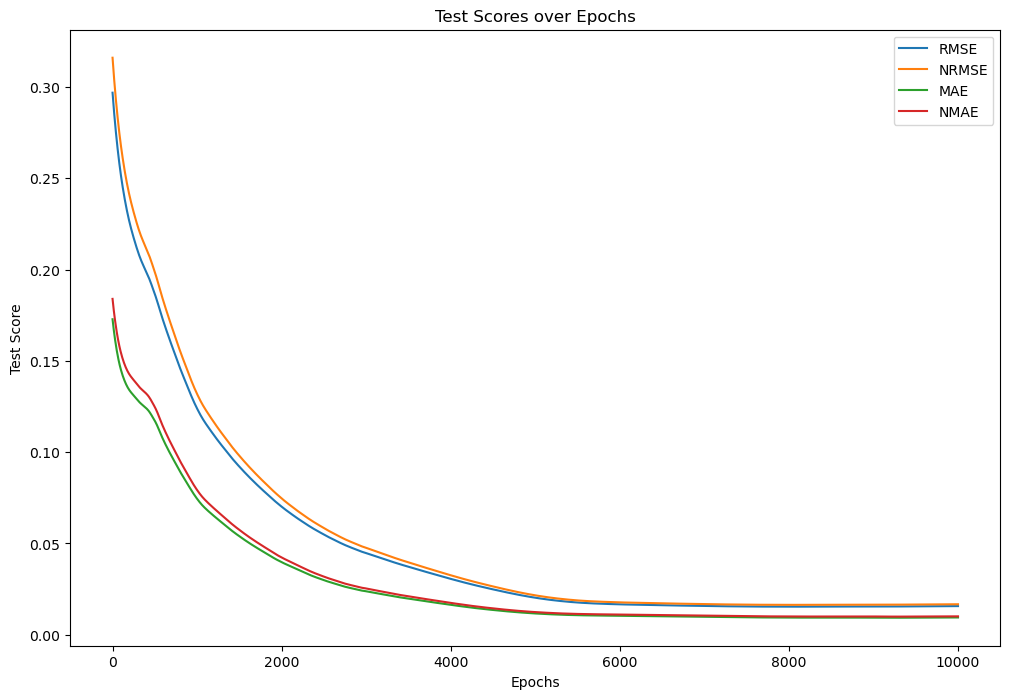

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(epochs, test_rmse, label='RMSE')
plt.plot(epochs, test_nrmse, label='NRMSE')
plt.plot(epochs, test_mae, label='MAE')
plt.plot(epochs, test_nmae, label='NMAE')

plt.xlabel('Epochs')
plt.ylabel('Test Score')
plt.title('Test Scores over Epochs')
plt.legend()

plt.show()

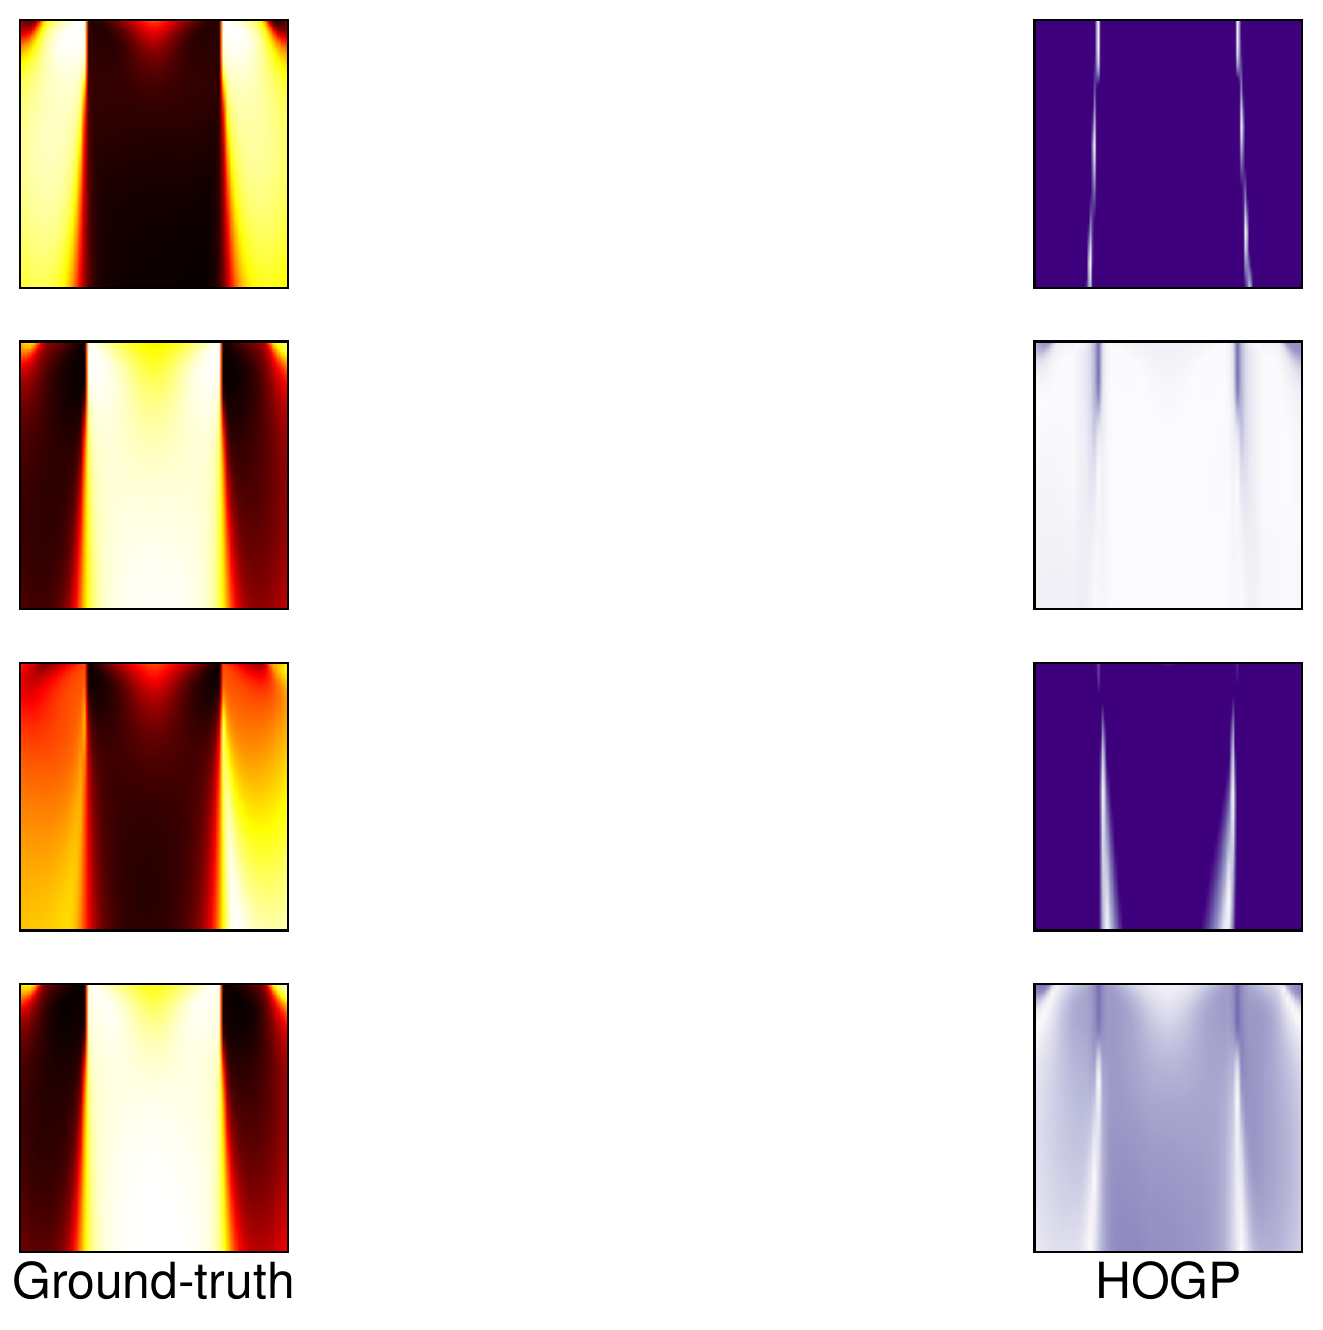

In [2]:
from pdf2image import convert_from_path
from IPython.display import Image, display
pdf_path = "__figs__/errors_Heat.pdf"

# Convert the PDF to images
images = convert_from_path(pdf_path)

images[0].save("__figs__/errors_Heat.png", 'PNG')

display(Image(filename='__figs__/errors_Heat.png'))

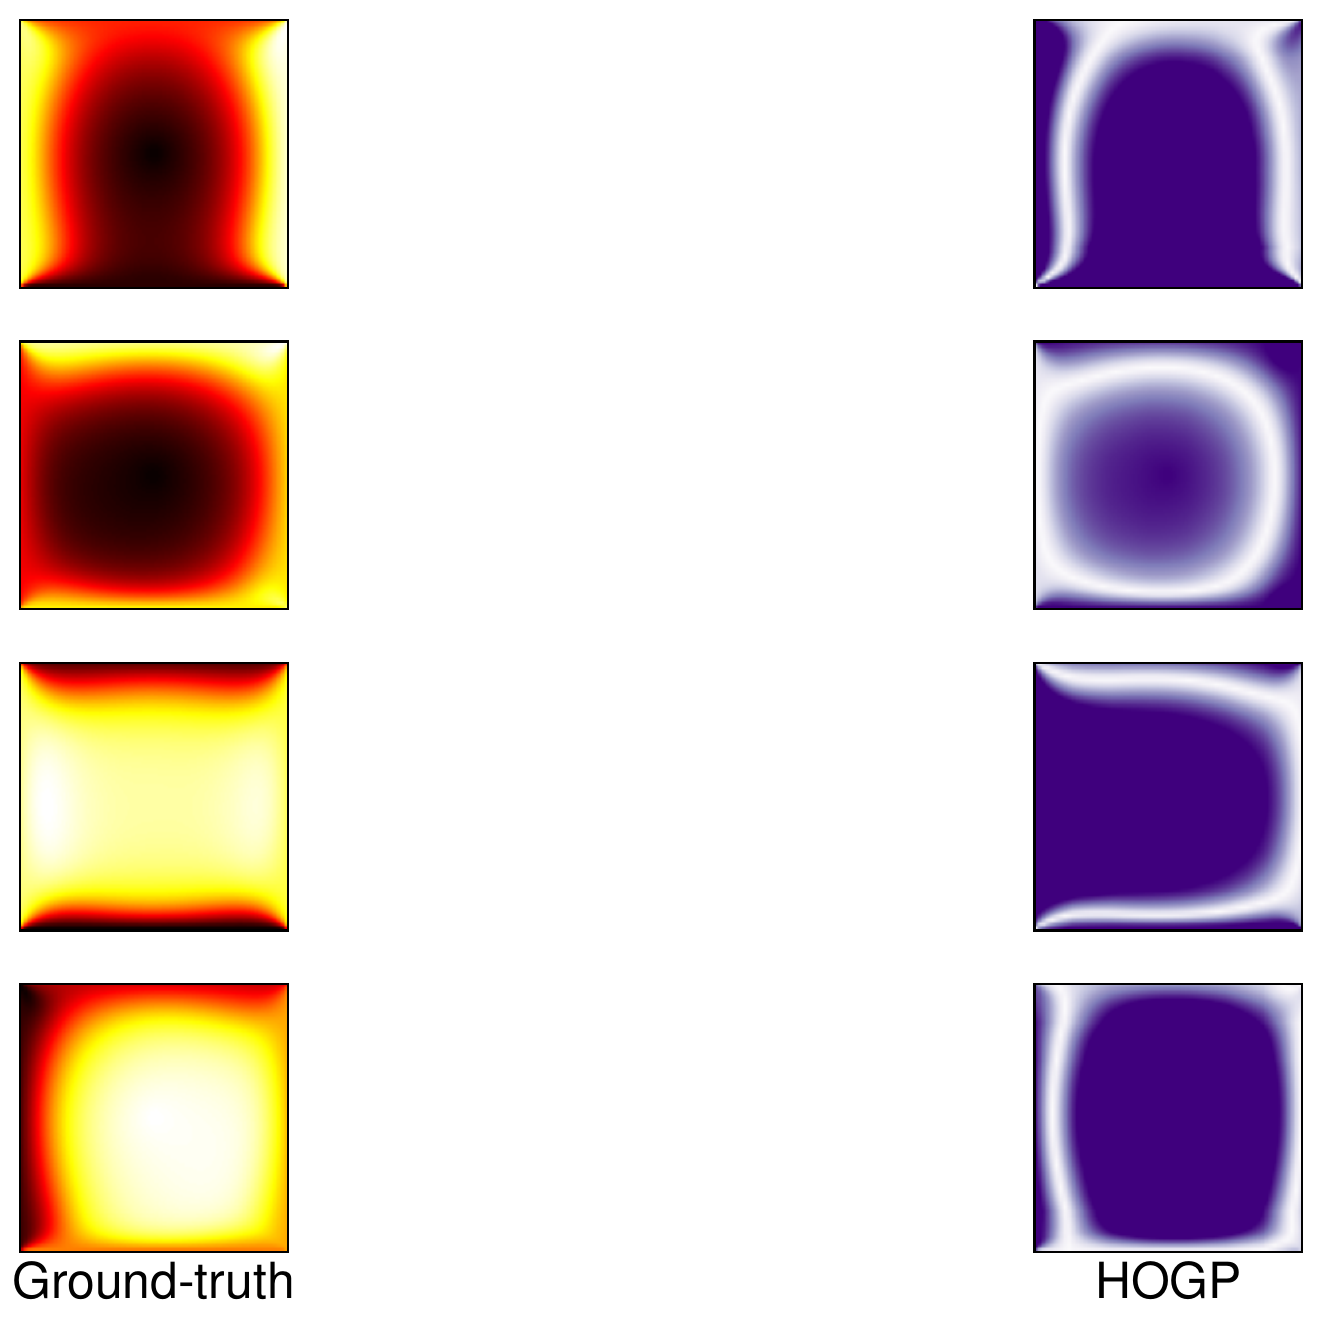

In [3]:
from pdf2image import convert_from_path
from IPython.display import Image, display
pdf_path = "__figs__/errors_Poisson.pdf"
images = convert_from_path(pdf_path)

images[0].save("__figs__/errors_Poisson.png", 'PNG')

display(Image(filename='__figs__/errors_Poisson.png'))